# Test NMF and dB-differencing using MBVS data

In [1037]:
import os, sys, glob, re
import datetime as dt
import numpy as np
from calendar import monthrange
from matplotlib.dates import date2num, num2date
# import h5py
from sklearn import decomposition
import nimfa
from scipy import signal

sys.path.insert(0,'/home/wu-jung/code_git/mi-instrument')
from mi.instrument.kut.ek60.ooicore.zplsc_b import *
# from concat_raw import get_num_days_pings, get_data_from_h5
# from echogram_decomp import find_nearest_time_idx,reshape_into_3freq,reshape_into_1freq,\
#     sep_into_freq,plot_decomp_v,plot_decomp_transform
from db_diff import *

import matplotlib.pyplot as plt
# from modest_image import imshow
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [433]:
%matplotlib inline

In [434]:
date_start = dt.date(2015,8,17)
date_end = dt.date(2015,10,17)
date_wanted = [(date_start+dt.timedelta(days=xx)).strftime('%Y%m%d') for xx in range((date_end-date_start).days + 1)]

In [435]:
data_path = '/media/wu-jung/wjlee_apl_2/ooi_zplsc_600m/'
save_path = '/media/wu-jung/wjlee_apl_2/ooi_zplsc_new/'
save_fname = '%s-%s' % (date_start.strftime('%Y%m%d'),date_end.strftime('%Y%m%d'))

In [546]:
# Set param
hour_all = range(24)
min_all = range(20)
sec_all = range(0,60,5)
ping_per_day = len(hour_all)*len(min_all)*len(sec_all)

ping_bin_range = 40
depth_bin_range = 10
tvg_correction_factor = 2

ping_per_day_mvbs = ping_per_day/ping_bin_range

*****************************************
## The section below is for testing stuff...

In [389]:
dd= date_wanted[60]
# load files and get calibration params
fname = glob.glob(os.path.join(data_path,'OOI-D%s*.raw' %dd))[0]
particle_data, data_times, power_data, freq, bin_size, config_header, config_transducer = \
    parse_echogram_file(fname)
cal_params = get_cal_params(power_data,particle_data,config_header,config_transducer)

# swap sequence of 120 kHz and 38 kHz cal_params and data
cal_params = [cal_params[fn] for fn in [1,0,2]]
power_data = get_power_data_mtx(power_data,freq)

# clean data
Sv_raw_tmp = np.ma.empty((power_data.shape))
Sv_corr_tmp = np.ma.empty((power_data.shape))
Sv_noise_tmp = np.ma.empty((power_data.shape[0:2]))
for fn in range(power_data.shape[0]):
    noise_est,ping_bin_num = get_noise(power_data[fn,:,:],bin_size,ping_bin_range,depth_bin_range)
    Sv_raw_tmp[fn,:,:],Sv_corr_tmp[fn,:,:],Sv_noise_tmp[fn,:] = \
            remove_noise(power_data[fn,:,:],cal_params[fn],noise_est.min(),ping_bin_range,tvg_correction_factor)

# set up indexing to get wanted pings
dd = dt.datetime.strptime(dd,'%Y%m%d')
time_wanted = [dt.datetime(dd.year,dd.month,dd.day,hh,mm,ss) for hh in hour_all for mm in min_all for ss in sec_all]
idx_wanted = [find_nearest_time_idx(data_times,tt,2) for tt in time_wanted]
notnanidx = np.argwhere(~np.isnan(idx_wanted)).flatten()
notnanidx_in_all = np.array(idx_wanted)[notnanidx].astype(int)

# get data to to saved
Sv_raw = np.ma.empty((Sv_raw.shape[0],Sv_raw.shape[1],ping_per_day))
Sv_corr = np.ma.empty((Sv_raw.shape[0],Sv_raw.shape[1],ping_per_day))
Sv_noise = np.ma.empty((Sv_raw.shape[0],Sv_raw.shape[1],1))

Sv_raw[:,:,notnanidx] = Sv_raw_tmp[:,:,notnanidx_in_all]
Sv_corr[:,:,notnanidx] = Sv_corr_tmp[:,:,notnanidx_in_all]
Sv_noise[:,:,0] = Sv_noise_tmp
ping_time = date2num(time_wanted)

idx_save_mask = np.argwhere(np.isnan(idx_wanted))
Sv_raw[:,:,idx_save_mask] = np.ma.masked
Sv_raw[:,:,idx_save_mask].mask = True
Sv_corr[:,:,idx_save_mask] = np.ma.masked
Sv_corr[:,:,idx_save_mask].mask = True

MVBS = get_MVBS(Sv_corr,bin_size,ping_bin_range,depth_bin_range=5)

2017-10-18 07:43:20,935 INFO     mi.instrument.kut.ek60.ooicore.zplsc_b Begin processing echogram data: '/media/wu-jung/wjlee_apl_2/ooi_zplsc_600m/OOI-D20151016-T000000.raw'


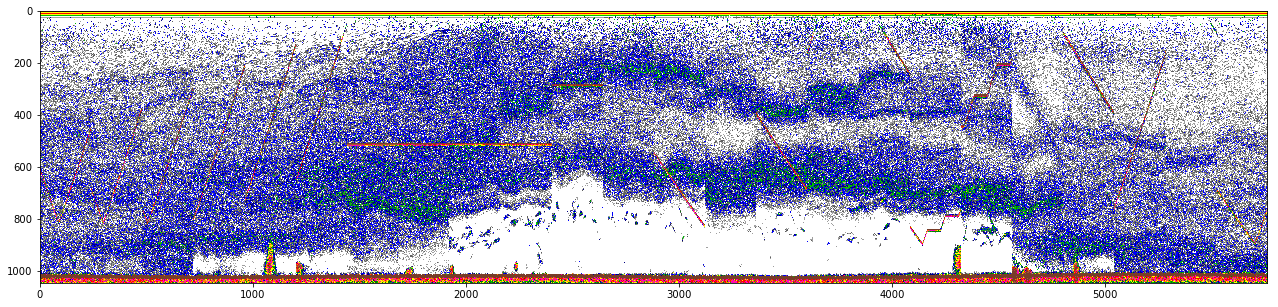

In [391]:
plt.subplots(figsize=(22,5))
plt.imshow(Sv_corr[0,:,:],aspect='auto',cmap=e_cmap,norm=e_norm)

In [392]:
idx_bkg = np.nonzero(Sv_corr<-40)

In [411]:
Sv_bkg = np.ma.copy(Sv_corr)

In [416]:
Sv_bkg[idx_bkg] = np.nan
Sv_bkg[idx_bkg].mask= True

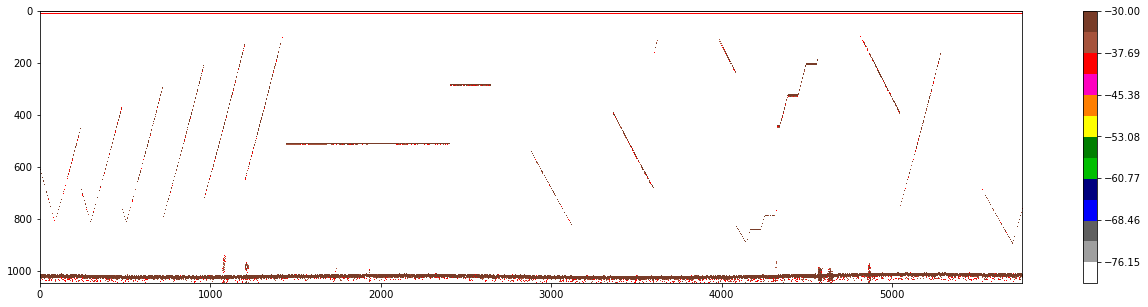

In [417]:
plt.subplots(figsize=(22,5))
plt.imshow(Sv_bkg[0,:,:],aspect='auto',cmap=e_cmap,norm=e_norm)
plt.colorbar()

In [421]:
import cv2

In [430]:
Sv_bkg_blur = cv2.filter2D(Sv_bkg[0,:,:],-1,np.ones((3,3),np.float32)/25)

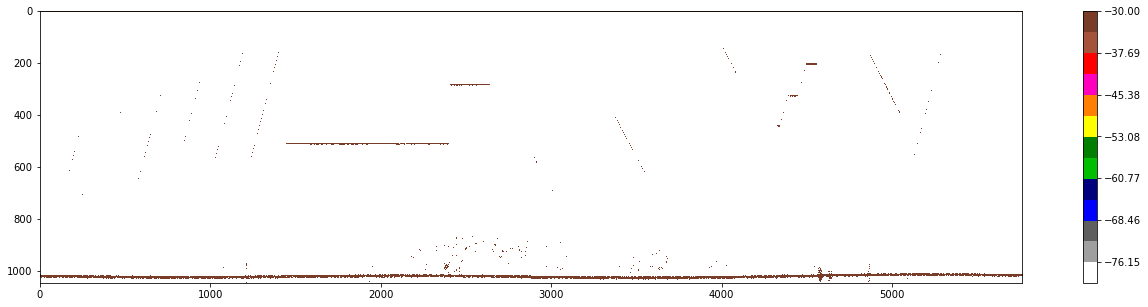

In [431]:
plt.subplots(figsize=(22,5))
plt.imshow(Sv_bkg_blur,aspect='auto',cmap=e_cmap,norm=e_norm)
plt.colorbar()

In [352]:
idx_large = np.nonzero(Sv_corr>-45)

In [357]:
Sv_corr[idx_large] = np.ma.masked

In [384]:
idx_large

(array([0, 0, 0, ..., 2, 2, 2]),
 array([   0,    0,    0, ..., 1045, 1045, 1045]),
 array([   0,    1,    2, ..., 5502, 5508, 5512]))

In [369]:
idx_large_array=np.array(idx_large)

In [371]:
idx_large_array

array([[   0,    0,    0, ...,    2,    2,    2],
       [   0,    0,    0, ..., 1045, 1045, 1045],
       [   0,    1,    2, ..., 5502, 5508, 5512]])

In [388]:
type(Sv_corr)

numpy.ma.core.MaskedArray

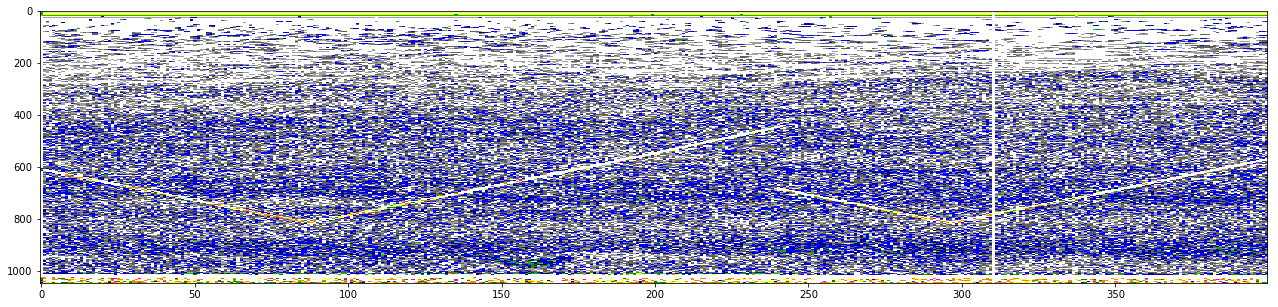

In [358]:
plt.subplots(figsize=(22,5))
plt.imshow(Sv_corr[0,:,0:400],aspect='auto',cmap=e_cmap,norm=e_norm)

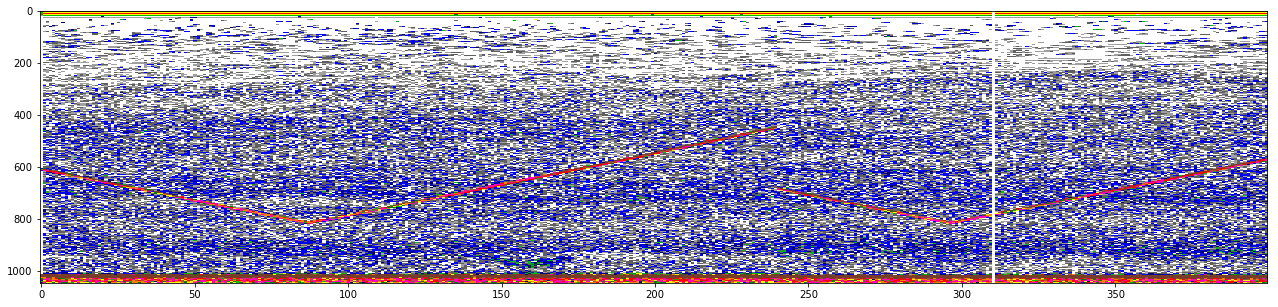

In [327]:
plt.subplots(figsize=(22,5))
plt.imshow(Sv_corr[0,:,0:400],aspect='auto',cmap=e_cmap,norm=e_norm)

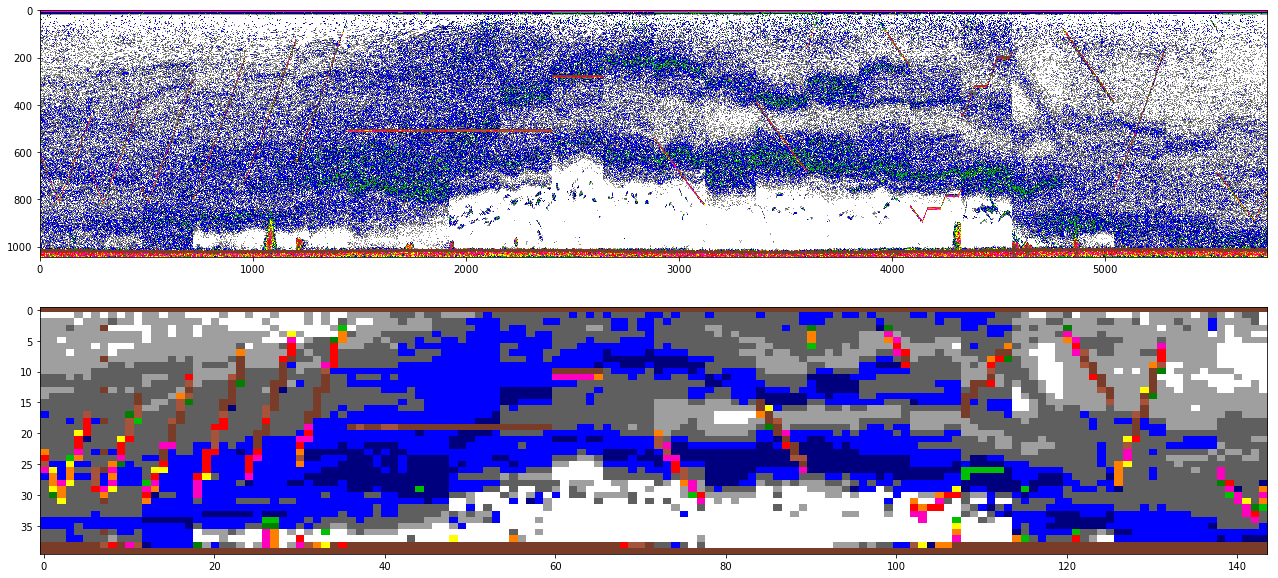

In [306]:
fig,ax = plt.subplots(2,1,figsize=(22,10))
ax[0].imshow(Sv_corr[0,:,:],aspect='auto',cmap=e_cmap,norm=e_norm)
ax[1].imshow(MVBS[0,:,:],aspect='auto',cmap=e_cmap,norm=e_norm)

In [363]:
Sv_corr_med0 = signal.medfilt2d(Sv_corr[0,:,:],kernel_size=9)

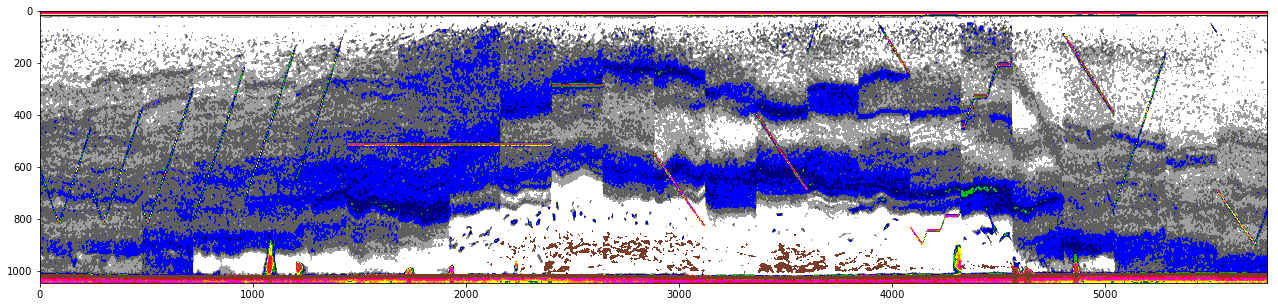

In [364]:
plt.subplots(figsize=(22,5))
plt.imshow(Sv_corr_med0,aspect='auto',cmap=e_cmap,norm=e_norm)

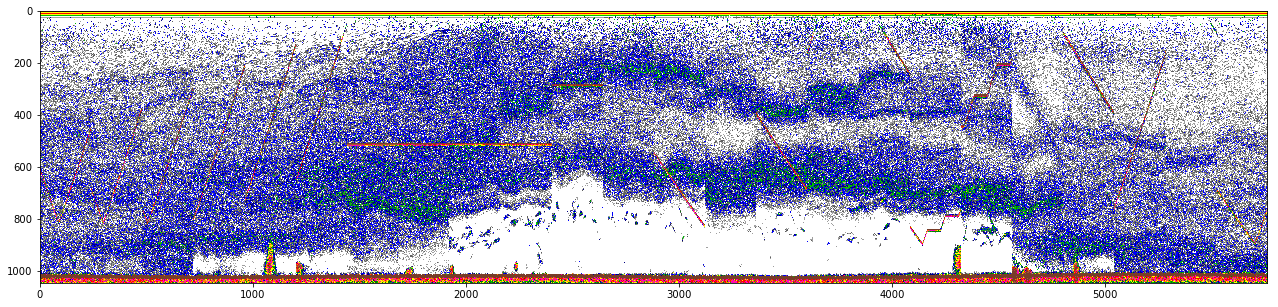

In [299]:
plt.subplots(figsize=(22,5))
plt.imshow(Sv_corr[0,:,:],aspect='auto',cmap=e_cmap,norm=e_norm)

## End of testing stuff...
************************************************************

## Unpack .Raw files into HDF5

In [437]:
for iD,dd in zip(range(len(date_wanted)),date_wanted):

    # load files and get calibration params
    fname = glob.glob(os.path.join(data_path,'OOI-D%s*.raw' %dd))[0]
    particle_data, data_times, power_data, freq, bin_size, config_header, config_transducer = \
        parse_echogram_file(fname)
    cal_params = get_cal_params(power_data,particle_data,config_header,config_transducer)

    # swap sequence of 120 kHz and 38 kHz cal_params and data
    cal_params = [cal_params[fn] for fn in [1,0,2]]
    power_data = get_power_data_mtx(power_data,freq)

    # clean data
    Sv_raw_tmp = np.ma.empty((power_data.shape))
    Sv_corr_tmp = np.ma.empty((power_data.shape))
    Sv_noise_tmp = np.ma.empty((power_data.shape[0:2]))
    for fn in range(power_data.shape[0]):
        noise_est,ping_bin_num = get_noise(power_data[fn,:,:],bin_size,ping_bin_range,depth_bin_range)
        Sv_raw_tmp[fn,:,:],Sv_corr_tmp[fn,:,:],Sv_noise_tmp[fn,:] = \
                remove_noise(power_data[fn,:,:],cal_params[fn],noise_est.min(),ping_bin_range,tvg_correction_factor)

    # set up indexing to get wanted pings
    dd = dt.datetime.strptime(dd,'%Y%m%d')
    time_wanted = [dt.datetime(dd.year,dd.month,dd.day,hh,mm,ss) for hh in hour_all for mm in min_all for ss in sec_all]
    idx_wanted = [find_nearest_time_idx(data_times,tt,2) for tt in time_wanted]
    notnanidx = np.argwhere(~np.isnan(idx_wanted)).flatten()
    notnanidx_in_all = np.array(idx_wanted)[notnanidx].astype(int)

    # get data to to saved
    Sv_raw = np.ma.empty((Sv_raw.shape[0],Sv_raw.shape[1],ping_per_day))
    Sv_corr = np.ma.empty((Sv_raw.shape[0],Sv_raw.shape[1],ping_per_day))
    Sv_noise = np.ma.empty((Sv_raw.shape[0],Sv_raw.shape[1],1))
    
    Sv_raw[:,:,notnanidx] = Sv_raw_tmp[:,:,notnanidx_in_all]
    Sv_corr[:,:,notnanidx] = Sv_corr_tmp[:,:,notnanidx_in_all]
    Sv_noise[:,:,0] = Sv_noise_tmp
    ping_time = date2num(time_wanted)

    idx_save_mask = np.argwhere(np.isnan(idx_wanted))
    Sv_raw[:,:,idx_save_mask] = np.ma.masked
    Sv_corr[:,:,idx_save_mask] = np.ma.masked
    
    # save into h5 file
    sz = Sv_raw.shape
    f = h5py.File(os.path.join(save_path,'%s_Sv.h5' %save_fname),"a")
    if "Sv_raw" in f:  # if file alread exist and contains Sv mtx
        print '-- H5 file exists, append new data mtx...'
        # append new data
        sz_exist = f['Sv_raw'].shape  # shape of existing Sv mtx
        f['Sv_raw'].resize((sz_exist[0],sz_exist[1],sz_exist[2]+sz[2]))
        f['Sv_raw'][:,:,sz_exist[2]:] = Sv_raw
        f['Sv_corr'].resize((sz_exist[0],sz_exist[1],sz_exist[2]+sz[2]))
        f['Sv_corr'][:,:,sz_exist[2]:] = Sv_corr
        f['Sv_noise'].resize((sz_exist[0],sz_exist[1],sz_exist[2]+1))
        f['Sv_noise'][:,:,sz_exist[2]:] = Sv_noise
        f['ping_time'].resize((sz_exist[2]+sz[2],))
        f['ping_time'][sz_exist[2]:] = ping_time
    else:
        print '-- New H5 file, create new dataset...'
        # create dataset and save
        f.create_dataset("Sv_raw", sz, maxshape=(sz[0],sz[1],None), data=Sv_raw, chunks=True)
        f.create_dataset("Sv_corr", sz, maxshape=(sz[0],sz[1],None), data=Sv_corr, chunks=True)
        f.create_dataset("Sv_noise", (Sv_raw.shape[0],Sv_raw.shape[1],1), maxshape=(sz[0],sz[1],None), data=Sv_noise, chunks=True)
        f.create_dataset("ping_time", (sz[2],), maxshape=(None,), data=ping_time, chunks=True)
        f.create_dataset("depth_bin_size",data=bin_size)
    f.close()

    # get MVBS
    MVBS = get_MVBS(Sv_corr,bin_size,ping_bin_range,depth_bin_range=5)
    
    # save into h5 file
    sz = MVBS.shape
    ping_time_MVBS = ping_time[0::ping_bin_range]  # get ping time every ping_bin_range for MVBS
    
    f = h5py.File(os.path.join(save_path,'%s_MVBS.h5' %save_fname),"a")
    if "MVBS" in f:  # if file alread exist and contains Sv mtx
        print '-- H5 file exists, append new data mtx...'
        # append new data
        sz_exist = f['MVBS'].shape  # shape of existing Sv mtx
        f['MVBS'].resize((sz_exist[0],sz_exist[1],sz_exist[2]+sz[2]))
        f['MVBS'][:,:,sz_exist[2]:] = MVBS
        f['ping_time'].resize((sz_exist[2]+sz[2],))
        f['ping_time'][sz_exist[2]:] = ping_time_MVBS
    else:
        print '-- New H5 file, create new dataset...'
        # create dataset and save
        f.create_dataset("MVBS", sz, maxshape=(sz[0],sz[1],None), data=MVBS, chunks=True)
        f.create_dataset("ping_time", (sz[2],), maxshape=(None,), data=ping_time_MVBS, chunks=True)
        f.create_dataset("depth_bin_size",data=depth_bin_range)
    f.close()

2017-10-24 17:34:14,928 INFO     mi.instrument.kut.ek60.ooicore.zplsc_b Begin processing echogram data: '/media/wu-jung/wjlee_apl_2/ooi_zplsc_600m/OOI-D20150817-T000000.raw'
-- New H5 file, create new dataset...
-- New H5 file, create new dataset...
2017-10-24 17:34:49,735 INFO     mi.instrument.kut.ek60.ooicore.zplsc_b Begin processing echogram data: '/media/wu-jung/wjlee_apl_2/ooi_zplsc_600m/OOI-D20150818-T000000.raw'
-- H5 file exists, append new data mtx...
-- H5 file exists, append new data mtx...
2017-10-24 17:35:23,713 INFO     mi.instrument.kut.ek60.ooicore.zplsc_b Begin processing echogram data: '/media/wu-jung/wjlee_apl_2/ooi_zplsc_600m/OOI-D20150819-T000000.raw'
-- H5 file exists, append new data mtx...
-- H5 file exists, append new data mtx...
2017-10-24 17:35:57,211 INFO     mi.instrument.kut.ek60.ooicore.zplsc_b Begin processing echogram data: '/media/wu-jung/wjlee_apl_2/ooi_zplsc_600m/OOI-D20150820-T000000.raw'
-- H5 file exists, append new data mtx...
-- H5 file exists,

***************************************************
## Load MVBS data and process

In [438]:
f = h5py.File(os.path.join(save_path,'%s_MVBS.h5' %save_fname),"r")

In [439]:
MVBS = np.array(f['MVBS'])

The echogram doesn't look so nice when plotting all 62 days together.

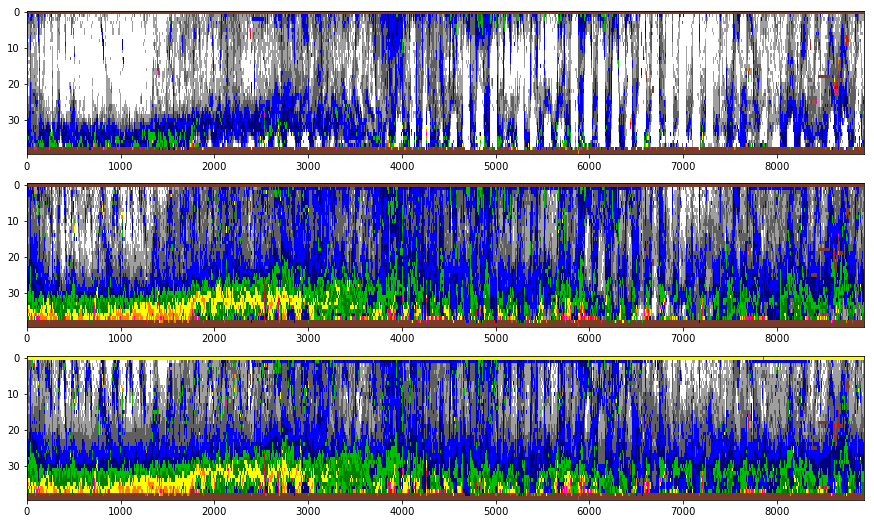

In [440]:
fig,ax = plt.subplots(3,1,figsize=(15,9))
ax[0].imshow(MVBS[0,:,0:],aspect='auto',cmap=e_cmap,norm=e_norm)
ax[1].imshow(MVBS[1,:,:],aspect='auto',cmap=e_cmap,norm=e_norm)
ax[2].imshow(MVBS[2,:,:],aspect='auto',cmap=e_cmap,norm=e_norm)

But the echogram structures are easier to see if only plotting out a shorter section. Below we plot the last 5 days, in which there are lots of returns from the profiler. Including these returns or not makes a difference in how the NMF decompose the data matrix.

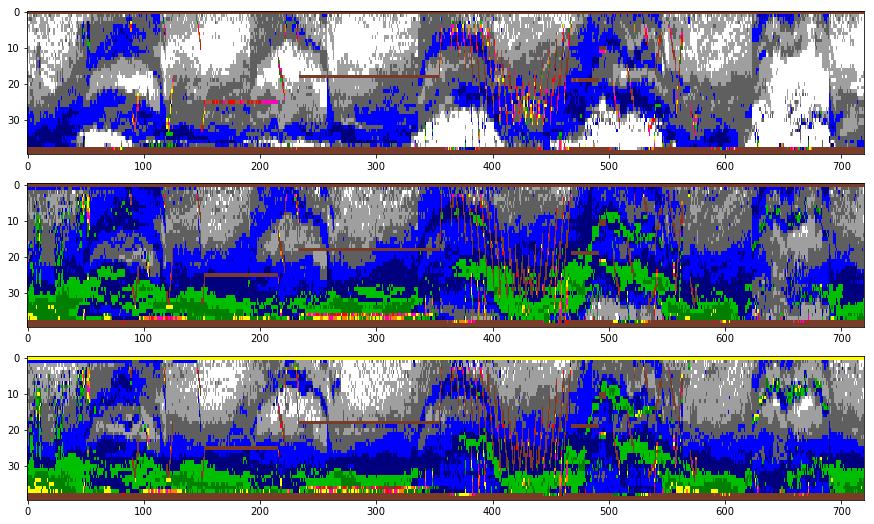

In [547]:
plot_start_day = 57
plot_range_day = 5
fig,ax = plt.subplots(3,1,figsize=(15,9))
ax[0].imshow(MVBS[0,:,ping_per_day_mvbs*plot_start_day+np.arange(ping_per_day_mvbs*plot_range_day)].T,aspect='auto',cmap=e_cmap,norm=e_norm)
ax[1].imshow(MVBS[1,:,ping_per_day_mvbs*plot_start_day+np.arange(ping_per_day_mvbs*plot_range_day)].T,aspect='auto',cmap=e_cmap,norm=e_norm)
ax[2].imshow(MVBS[2,:,ping_per_day_mvbs*plot_start_day+np.arange(ping_per_day_mvbs*plot_range_day)].T,aspect='auto',cmap=e_cmap,norm=e_norm)

***************************************
## Functions for plotting

In [1288]:
def plot_single_day(V,plot_day,save_fname='test.png'):
    plot_range_day = 1
    fig,ax = plt.subplots(1,3,figsize=(18,3))
    
    # Get color axis limtis
    v_mtx = V[:,1:-2,ping_per_day_mvbs*(plot_day-1)+np.arange(ping_per_day_mvbs*plot_range_day)]
    cmean = np.mean(v_mtx.reshape((-1,1)))
    cstd = np.std(v_mtx.reshape((-1,1)))
    cmax = np.max(v_mtx.reshape((-1,1)))

    for iX in range(3):
        im = ax[iX].imshow(v_mtx[iX,:,:],aspect='auto',vmax=cmean+cstd*6,vmin=cmean-cstd*3)#,cmap=e_cmap,norm=e_norm)
        divider = make_axes_locatable(ax[iX])
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(im,cax=cax)
        if iX==0:
            ax[iX].set_title('38 kHz')
        elif iX==1:
            ax[iX].set_title('120 kHz')
        else:
            ax[iX].set_title('200 kHz')
    plt.savefig(os.path.join(save_path,save_fname))    

In [1446]:
def plot_comp(V,figsize_input,save_fname='test.png',log_opt=1):
    fig,ax=plt.subplots(n_comp,1,sharex=True,figsize=figsize_input)
    for c in range(n_comp):
        if log_opt==1:
            vlog = 10*np.ma.log10(V[c,:,:])
        else:
            vlog = V[c,:,:]
        cmean = np.mean(vlog)
        cstd = np.std(vlog)
        cmin = max((np.min(vlog),cmean-2*cstd))
        cmax = min((np.max(vlog),cmean+4*cstd))
        ax[c].imshow(vlog,aspect='auto',vmin=cmin,vmax=cmax)
        ax[c].set_xticks([x*ping_per_day_mvbs+ping_per_day_mvbs/2 for x in range(3)])
        ax[c].set_xticklabels(['38k','120k','200k'])
        ax[c].tick_params('both', length=0)
    plt.savefig(os.path.join(save_path,save_fname))

In [1235]:
def plot_coef(W,yscale=0,save_fname='test.png'):
    plt.figure(figsize=(22,3))
    W[W==0] = sys.float_info.epsilon
    labels = [str(x) for x in range(n_comp)]
    for w, label in zip(W.T, labels):
        plt.plot(range(1,len(w)+1),w, label=label,linewidth=2)
    plt.legend()
    plt.xticks(range(mvbs_long.shape[0]))
    if yscale==1:
        plt.yscale('log')
    plt.xlim([0,mvbs_long.shape[0]])
    plt.savefig(os.path.join(save_path,save_fname))
    plt.show()

In [1458]:
def plot_cmp_data_decomp(V,X,plot_day,figsize_input,save_fname='test.png',same_cax_opt=1):
    plot_range_day = 1
    fig,ax = plt.subplots(2,3,figsize=figsize_input)
    for iY in range(2):
        # Get color axis limtis
        v_mtx = V[:,1:-2,ping_per_day_mvbs*(plot_day-1)+np.arange(ping_per_day_mvbs*plot_range_day)].reshape((-1,1))
        cmean = np.mean(v_mtx)
        cstd = np.std(v_mtx)
        cmax = np.max(v_mtx)

        for iX in range(3):
            if iY==0:
                v = V[iX,1:-2,ping_per_day_mvbs*(plot_day-1)+np.arange(ping_per_day_mvbs*plot_range_day)]   # data to be plotted
            else:
                v = X[iX,:,ping_per_day_mvbs*(plot_day-1)+np.arange(ping_per_day_mvbs*plot_range_day)]   # data to be plotted

            if same_cax_opt==1:
                im = ax[iY,iX].imshow(v.T,aspect='auto',vmax=cmean+cstd*6,vmin=cmean-cstd*3)#,cmap=e_cmap,norm=e_norm)
            else:
                im = ax[iY,iX].imshow(v.T,aspect='auto')#,cmap=e_cmap,norm=e_norm)
            divider = make_axes_locatable(ax[iY,iX])
            cax = divider.append_axes("right", size="5%", pad=0.1)
            cbar = plt.colorbar(im,cax=cax)
            if iX==0:
                ax[iY,iX].set_title('38 kHz')
            elif iX==1:
                ax[iY,iX].set_title('120 kHz')
            else:
                ax[iY,iX].set_title('200 kHz')
    plt.savefig(os.path.join(save_path,save_fname))

In [1445]:
def separate_transform(D,ori_data,log_opt=1):
#     D_pca_LOG = pca.inverse_transform(W).copy()
    D_long = D.reshape((D.shape[0],-1,ori_data.shape[1])).swapaxes(1,2)
    D_sep = D_long.reshape((D_long.shape[0],D_long.shape[1],-1,ping_per_day_mvbs)).transpose((2,0,1,3))
    if log_opt==1:
        D_plot = 10*np.log10(D_sep.transpose((0,2,1,3))).reshape((D_sep.shape[0],D_sep.shape[2],-1))
    else:
        D_plot = D_sep.transpose((0,2,1,3)).reshape((D_sep.shape[0],D_sep.shape[2],-1))
    return D_sep,D_plot

***************************************************
## NMF in the linear domain

The decomposition seems to be dominated by echoes from the profiler when running NMF in the linear domain. I tested how the decomposition would change depending on if or not the last 3 days of data are included in the data for decomposition.

### *Not* include data from the last 3 days

In all decomposition below I took out the first and last 2 depth bins. The first depth bin is blank-out region of the transducer. The last 2 depth bins are returns from the sea surface. They seem to throw off NMF and result into one strong component that contains data from these depth bins.

In the first test below I did not include data from the last 3 days in the decomposition (the profiler echoes are very strong in day -2).

In [1332]:
mvbs = 10**(MVBS[:,1:-2,:-3*ping_per_day_mvbs]/10)
mvbs_3freq = np.array([mvbs[ff,:,:].T.reshape((-1,ping_per_day_mvbs*mvbs.shape[1])) for ff in range(3)])
mvbs_long = mvbs_3freq.swapaxes(0,1).reshape((-1,ping_per_day_mvbs*mvbs.shape[1]*3))

In [1333]:
n_comp = 5
nmf_59 = decomposition.NMF(n_components=n_comp)
W_59 = nmf_59.fit_transform(mvbs_long)
H_59 = nmf_59.components_
V_59 = H_59.reshape((n_comp,3*ping_per_day_mvbs,-1)).swapaxes(1,2)

Below let's first check the components from NMF (`H`). It seems like that the algorithm treats the profiler echoes as _signal_ and nothing else... and the actual movements of the animals were not driving the decomposition.

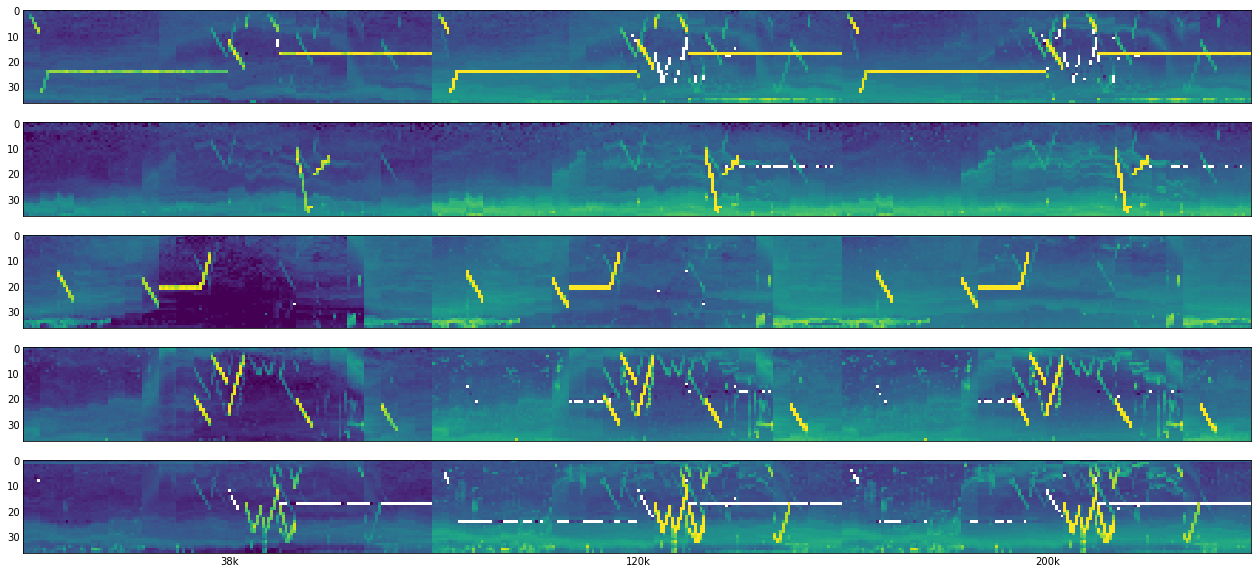

In [1334]:
plot_comp(V=V_59,figsize_input=(22,10),save_fname='59days_frob_5comp.png')

Below are the coefficients/mapping/coactivation for the components (`W`). The coefficients are plotted in the _log_ domain so that we could see small values. It is obvious that each of the components was activated mostly just once (i.e., in one day within the 60 days of data).

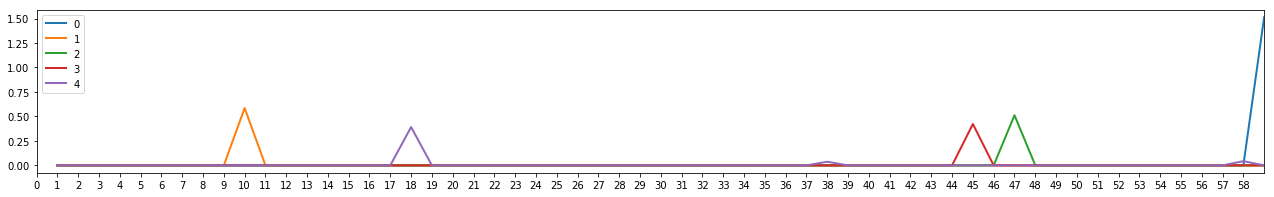

In [1335]:
plot_coef(W_59,save_fname='59days_frob_5comp_coef.png')

To check if these mappings make sense, below I check the original data for a few days where there is a peak from one of the components.

We can see that for Day 10, the max-activated component (component #1 in the above figure) does correspond with the dominant profiler echo pattern for that day.

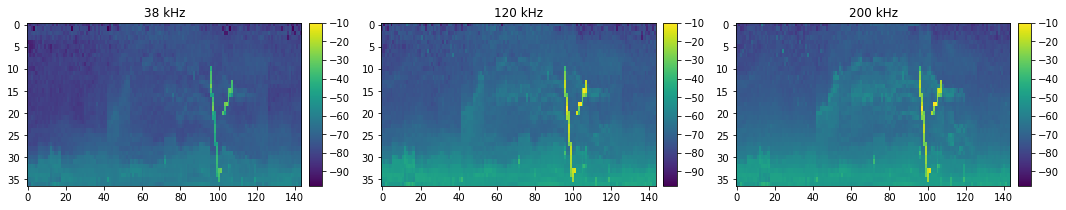

In [1336]:
dday = 10;
plot_single_day(V=MVBS,plot_day=dday,save_fname='ori_data_day%02d.png'%dday)

The mapping seems to work well for Day 18 and Day 59 as well. Day 18 corresponds with component #4, and Day 59 correspond with component #0).

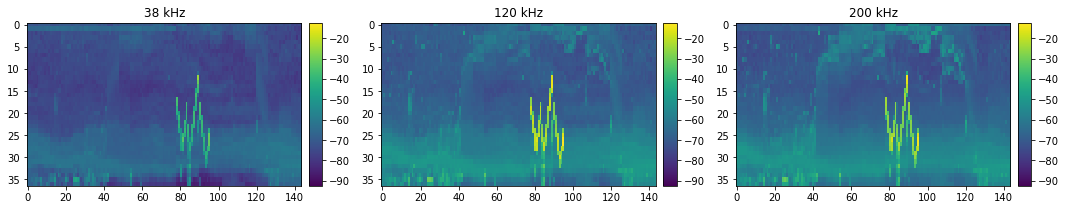

In [1337]:
dday = 18;
plot_single_day(V=MVBS,plot_day=dday,save_fname='ori_data_day%02d.png'%dday)

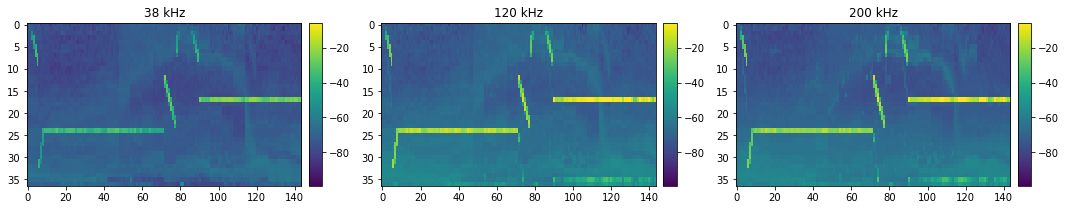

In [1338]:
dday = 59;
plot_single_day(V=MVBS,plot_day=dday,save_fname='ori_data_day%02d.png'%dday)

But for Day 38 the mapping doesn't seem to work as well.

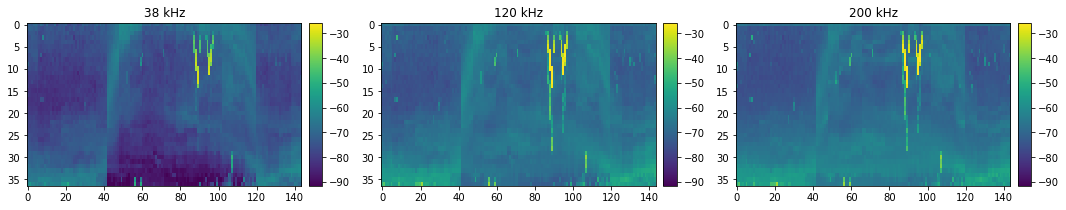

In [1339]:
dday = 38;
plot_single_day(V=MVBS,plot_day=dday,save_fname='ori_data_day%02d.png'%dday)

Below I try to compare the original and reconstructed data. The results are in general pretty good... Although it does seem like that the reconstruction very often would introduce noise into the echogram (spurious lines resulting from some of the components).

In [1340]:
D = nmf_min.inverse_transform(W_59).copy()
D_long = D.reshape((D.shape[0],-1,mvbs.shape[1])).swapaxes(1,2)
D_sep = D_long.reshape((D_long.shape[0],D_long.shape[1],-1,ping_per_day_mvbs)).transpose((2,0,1,3))
D_plot = 10*np.log10(D_sep.transpose((0,2,1,3))).reshape((D_sep.shape[0],D_sep.shape[2],-1))

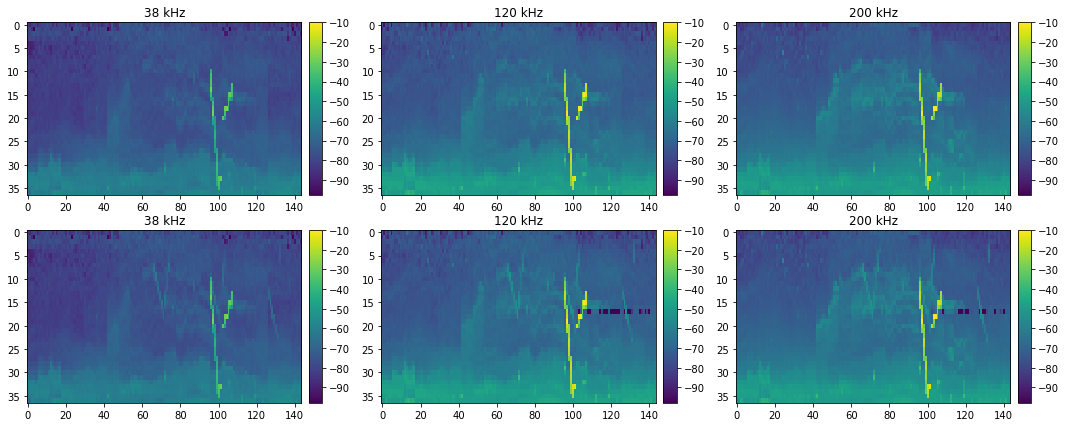

In [1341]:
dday = 10
plot_cmp_data_decomp(V=MVBS,X=D_plot,plot_day=dday,figsize_input=(18,7),save_fname='59days_frob_5comp_reconst%02d.png'%dday)

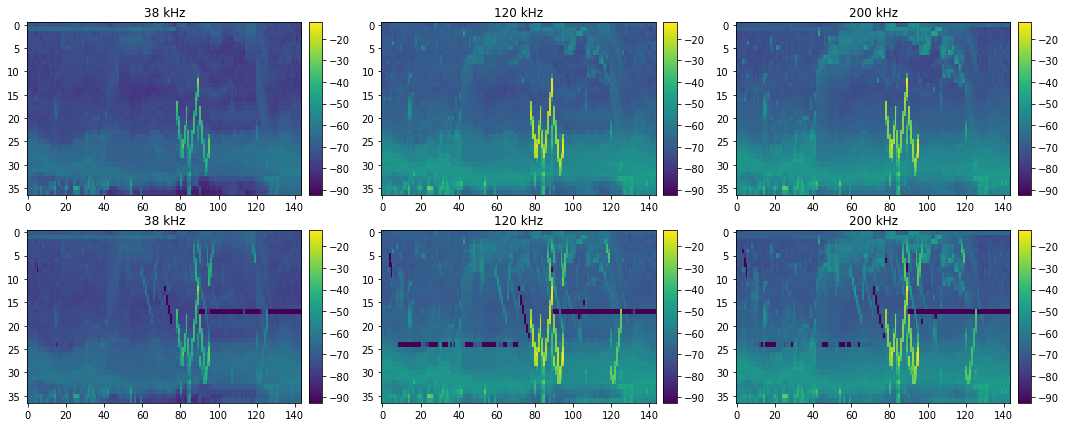

In [1342]:
dday = 18
plot_cmp_data_decomp(V=MVBS,X=D_plot,plot_day=dday,figsize_input=(18,7),save_fname='59days_frob_5comp_reconst%02d.png'%dday)

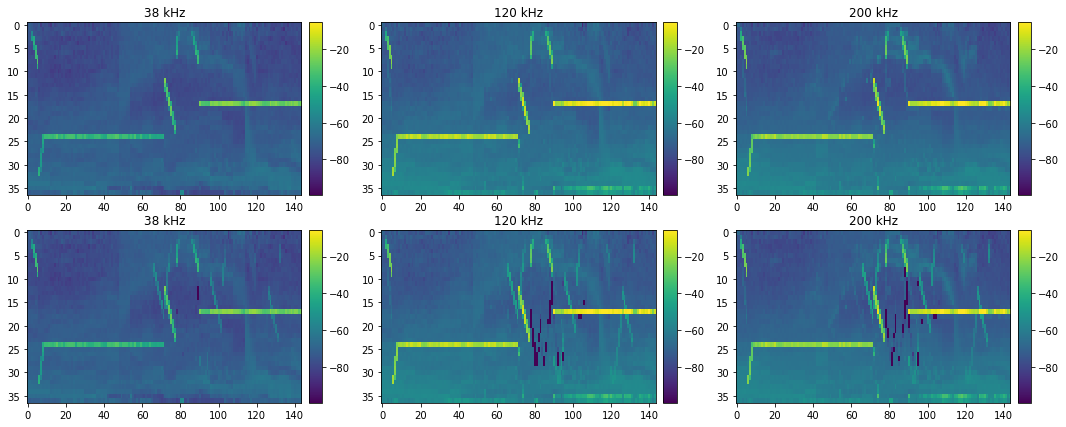

In [1343]:
dday = 59
plot_cmp_data_decomp(V=MVBS,X=D_plot,plot_day=dday,figsize_input=(18,7),save_fname='59days_frob_5comp_reconst%02d.png'%dday)

What's interesting is that the NMF decomposition seems to capture the _background_ animal movements pretty well too, even though the energy is really dominated by the profiler echoes.

However for days where there is no strong profiler echoes, the rescontruction doesn't work so well...

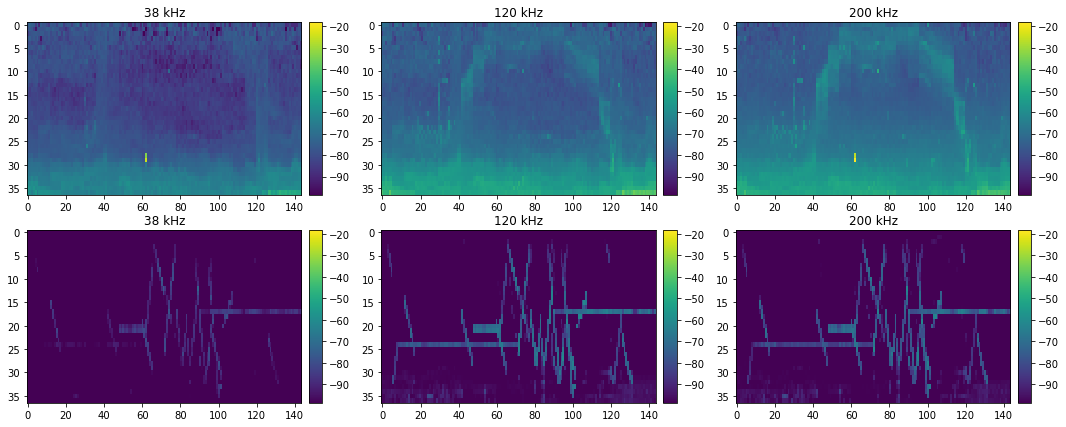

In [1344]:
dday = 5
plot_cmp_data_decomp(V=MVBS,X=D_plot,plot_day=dday,figsize_input=(18,7),save_fname='59days_frob_5comp_reconst%02d.png'%dday)

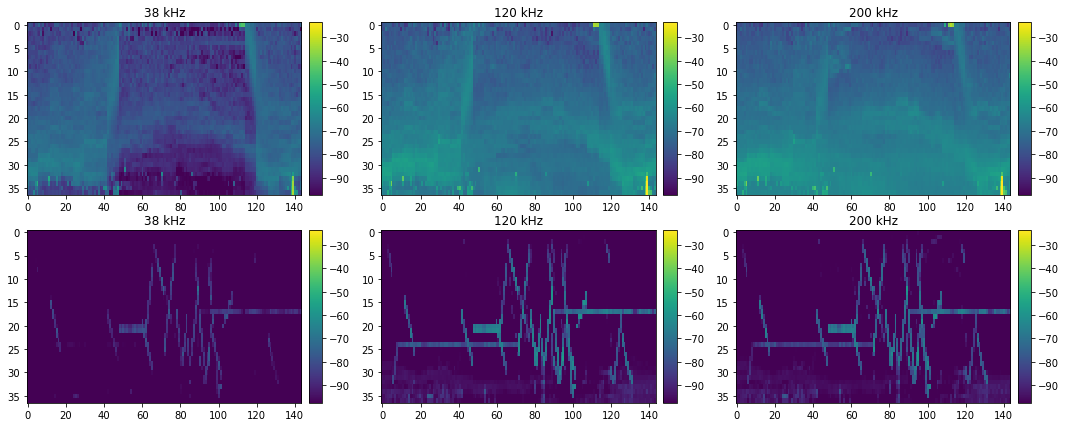

In [1345]:
dday = 50
plot_cmp_data_decomp(V=MVBS,X=D_plot,plot_day=dday,figsize_input=(18,7),save_fname='59days_frob_5comp_reconst%02d.png'%dday)

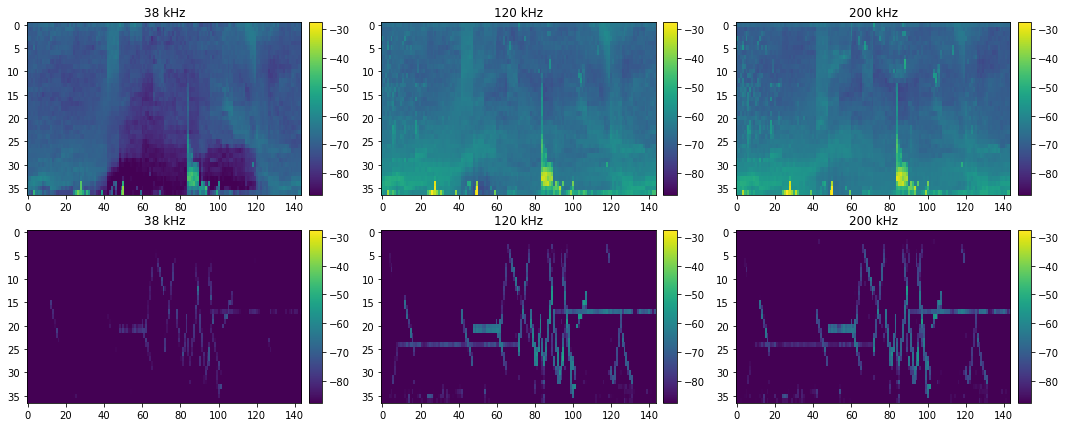

In [1346]:
dday = 30
plot_cmp_data_decomp(V=MVBS,X=D_plot,plot_day=dday,figsize_input=(18,7),save_fname='59days_frob_5comp_reconst%02d.png'%dday)

In the next step I am testing how increasing the number of components may change the decomposition.

### Include data from all days

If we include data from the last 3 days in the decomposition the results are quite a bit messier in terms of having the profiler echoes dominating the components.

In [1360]:
mvbs = 10**(MVBS[:,1:-2,:]/10)
mvbs_3freq = np.array([mvbs[ff,:,:].T.reshape((-1,ping_per_day_mvbs*mvbs.shape[1])) for ff in range(3)])
mvbs_long = mvbs_3freq.swapaxes(0,1).reshape((-1,ping_per_day_mvbs*mvbs.shape[1]*3))

In [1361]:
n_comp = 5
nmf_61 = decomposition.NMF(n_components=n_comp)
W_61 = nmf_61.fit_transform(mvbs_long)
H_61 = nmf_61.components_
V_61 = H_61.reshape((n_comp,3*ping_per_day_mvbs,-1)).swapaxes(1,2)

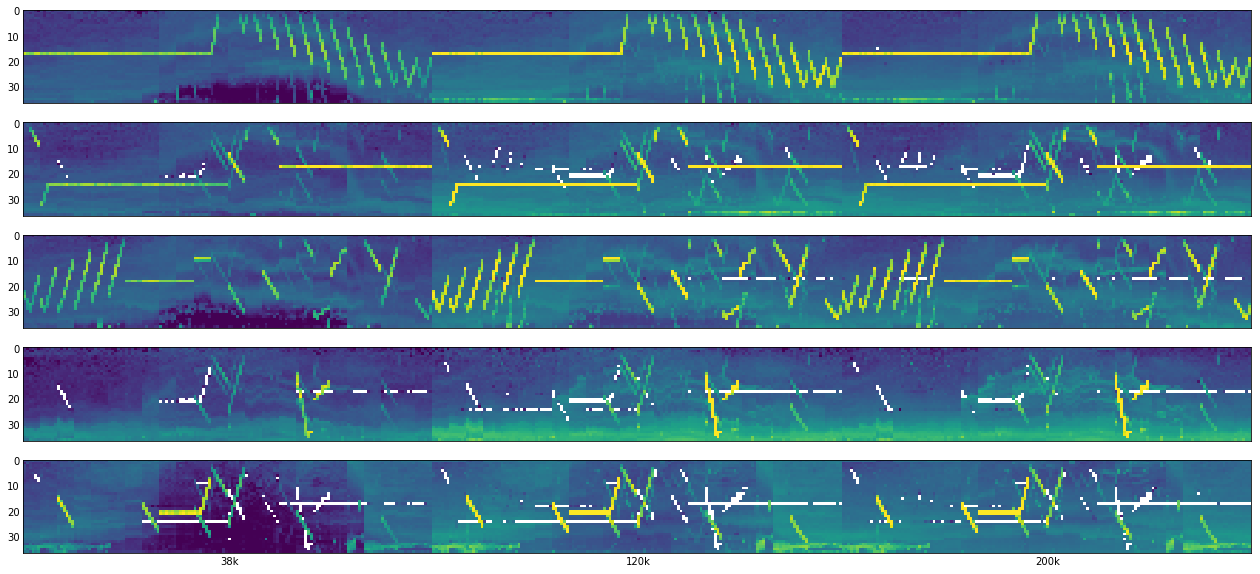

In [1362]:
plot_comp(V=V_61,figsize_input=(22,10),save_fname='61days_frob_5comp.png')

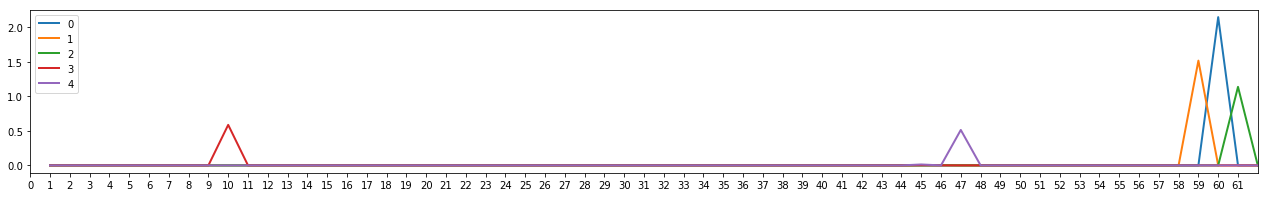

In [1363]:
plot_coef(W_61,save_fname='61days_frob_5comp_coef.png')

Now looking at the reconstruction again:

In [1364]:
D_61 = nmf_61.inverse_transform(W_61).copy()
D_61_long = D_61.reshape((D_61.shape[0],-1,mvbs.shape[1])).swapaxes(1,2)
D_61_sep = D_61_long.reshape((D_61_long.shape[0],D_61_long.shape[1],-1,ping_per_day_mvbs)).transpose((2,0,1,3))
D_61_plot = 10*np.log10(D_61_sep.transpose((0,2,1,3))).reshape((D_61_sep.shape[0],D_61_sep.shape[2],-1))

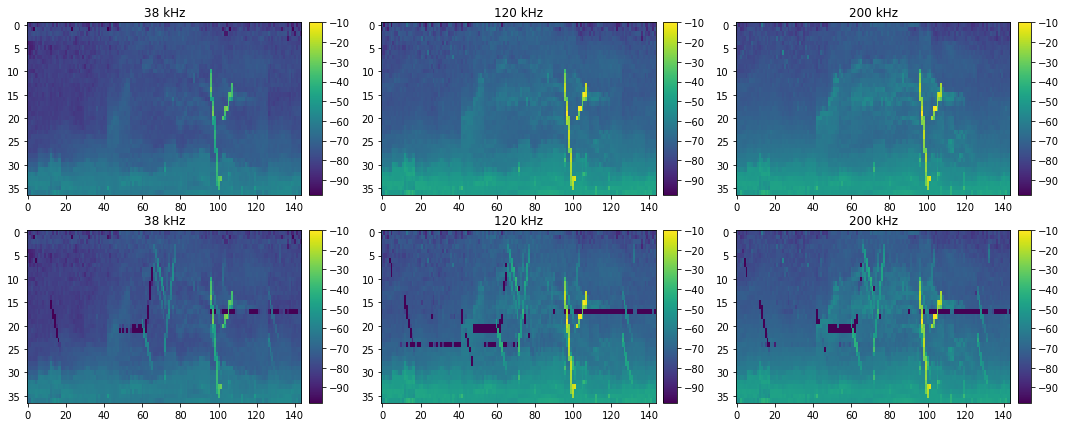

In [1365]:
dday = 10
plot_cmp_data_decomp(V=MVBS,X=D_61_plot,plot_day=dday,figsize_input=(18,7),save_fname='61days_frob_5comp_reconst%02d.png'%dday)

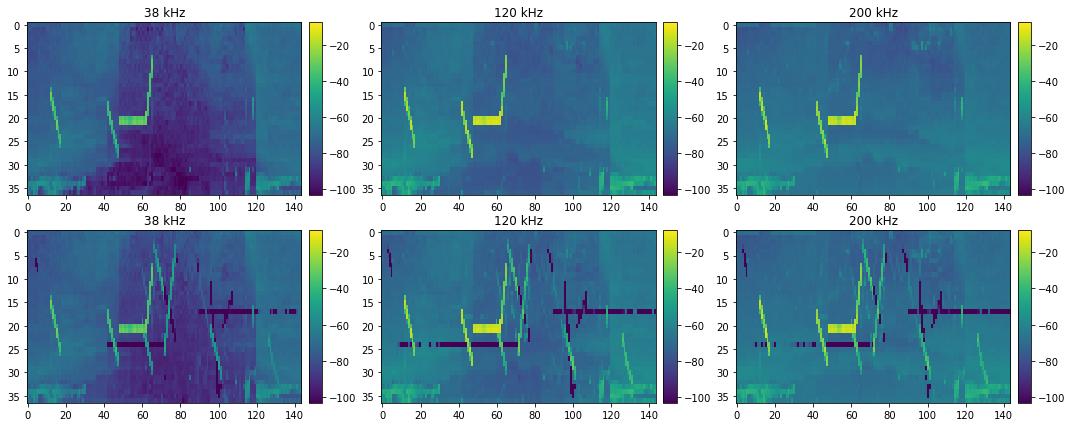

In [1366]:
dday = 47
plot_cmp_data_decomp(V=MVBS,X=D_61_plot,plot_day=dday,figsize_input=(18,7),save_fname='61days_frob_5comp_reconst%02d.png'%dday)

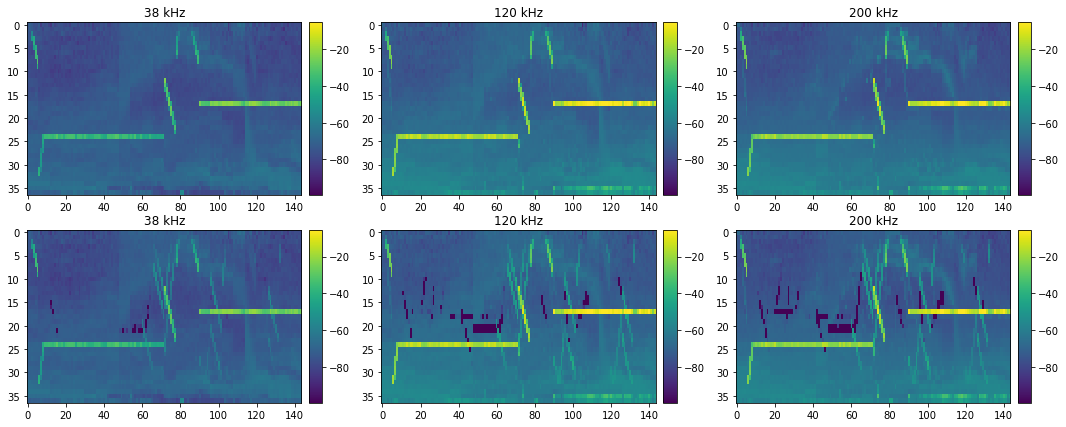

In [1367]:
dday = 59
plot_cmp_data_decomp(V=MVBS,X=D_61_plot,plot_day=dday,figsize_input=(18,7),save_fname='61days_frob_5comp_reconst%02d.png'%dday)

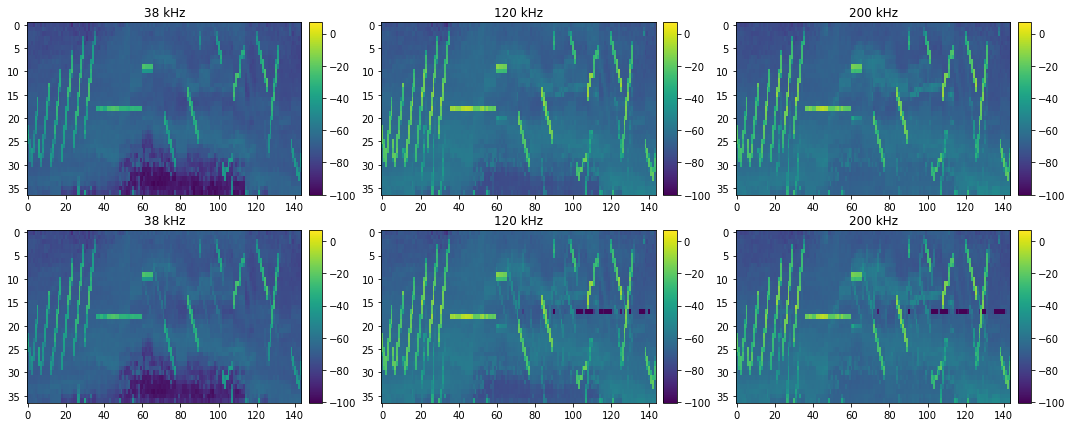

In [1368]:
dday = 61
plot_cmp_data_decomp(V=MVBS,X=D_61_plot,plot_day=dday,figsize_input=(18,7),save_fname='61days_frob_5comp_reconst%02d.png'%dday)

Again it does seem like that the reconstruction very often would introduce noise into the echogram (spurious lines resulting from some of the components). In general, it seems like by including the very high-energy profiler echoes in the last 3 days into the decopmosition, the resulting decomposition and reconstruction results are worse than without them.

It's also interesting to see how reconstruction works for the days without strong profiler echoes. It seems like that the reconstruction results are in general pretty bad...

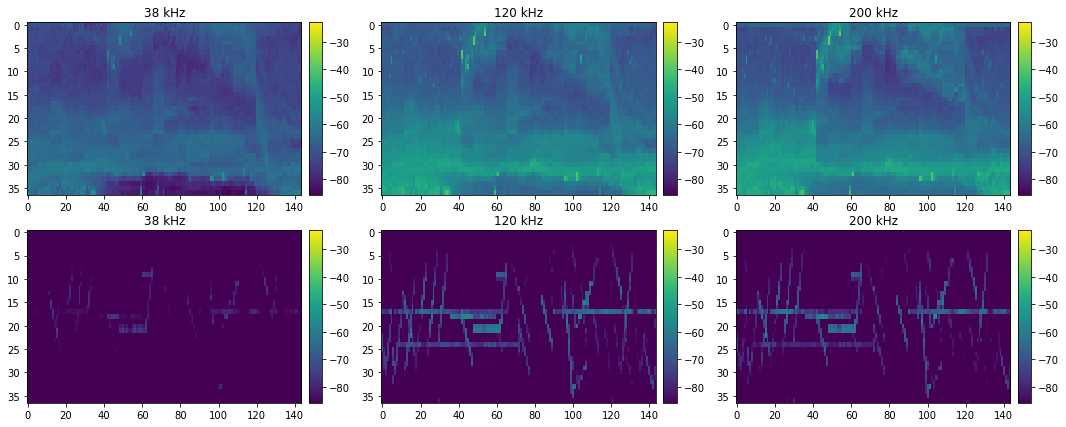

In [1369]:
dday = 20
plot_cmp_data_decomp(V=MVBS,X=D_61_plot,plot_day=dday,figsize_input=(18,7),save_fname='61days_frob_5comp_reconst%02d.png'%dday)

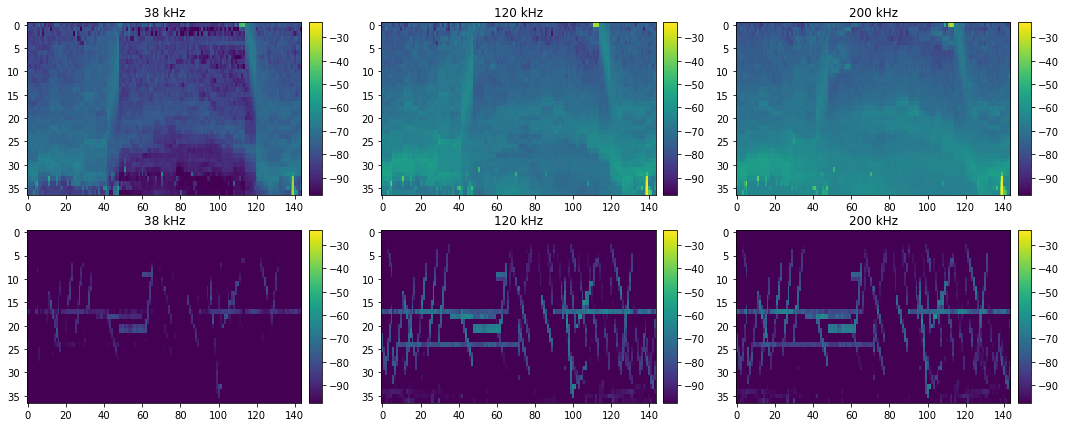

In [1370]:
dday = 50
plot_cmp_data_decomp(V=MVBS,X=D_61_plot,plot_day=dday,figsize_input=(18,7),save_fname='61days_frob_5comp_reconst%02d.png'%dday)

### Include data from all days but with more number of components

In [1371]:
mvbs = 10**(MVBS[:,1:-2,:]/10)
mvbs_3freq = np.array([mvbs[ff,:,:].T.reshape((-1,ping_per_day_mvbs*mvbs.shape[1])) for ff in range(3)])
mvbs_long = mvbs_3freq.swapaxes(0,1).reshape((-1,ping_per_day_mvbs*mvbs.shape[1]*3))

In [1372]:
n_comp = 8
nmf_61_8 = decomposition.NMF(n_components=n_comp)
W_61_8 = nmf_61_8.fit_transform(mvbs_long)
H_61_8 = nmf_61_8.components_
V_61_8 = H_61_8.reshape((n_comp,3*ping_per_day_mvbs,-1)).swapaxes(1,2)

In [1373]:
D_61_8 = nmf_61_8.inverse_transform(W_61_8).copy()
D_61_8_long = D_61_8.reshape((D_61_8.shape[0],-1,mvbs.shape[1])).swapaxes(1,2)
D_61_8_sep = D_61_8_long.reshape((D_61_8_long.shape[0],D_61_8_long.shape[1],-1,ping_per_day_mvbs)).transpose((2,0,1,3))
D_61_8_plot = 10*np.log10(D_61_8_sep.transpose((0,2,1,3))).reshape((D_61_8_sep.shape[0],D_61_8_sep.shape[2],-1))

/home/wu-jung/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log10


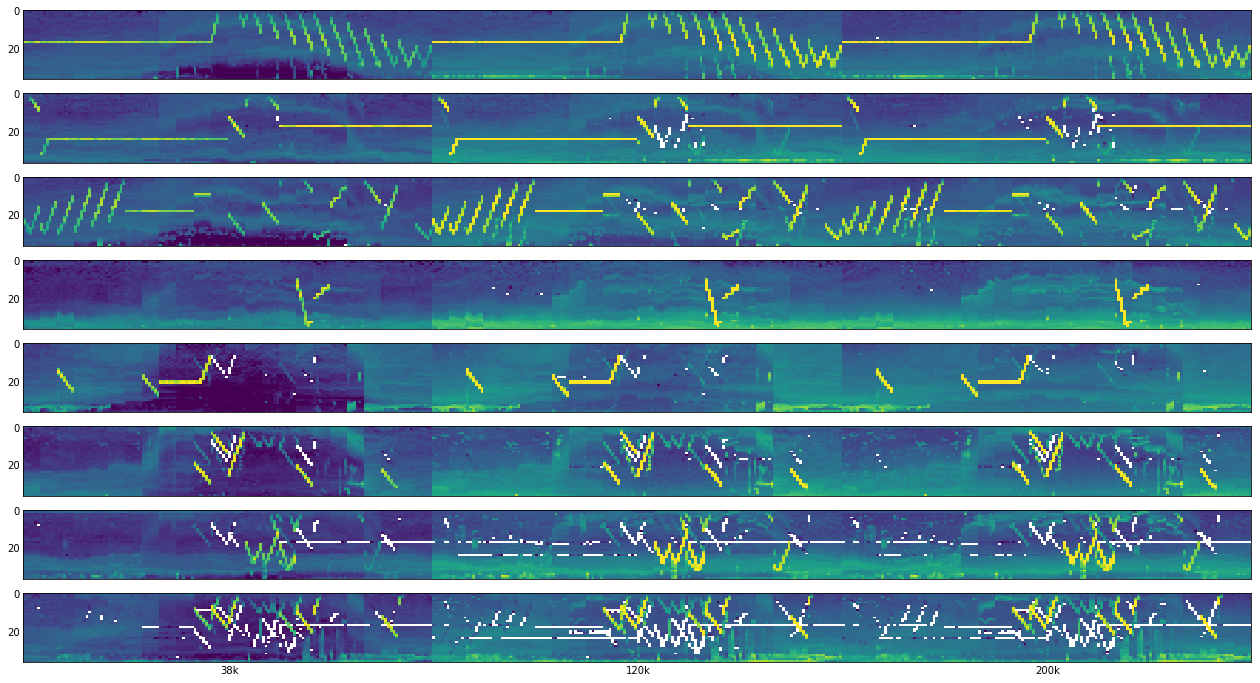

In [1374]:
plot_comp(V=V_61_8,figsize_input=(22,12),save_fname='61days_frob_8comp.png')

Below is the coefficients from NMF with 8 components.

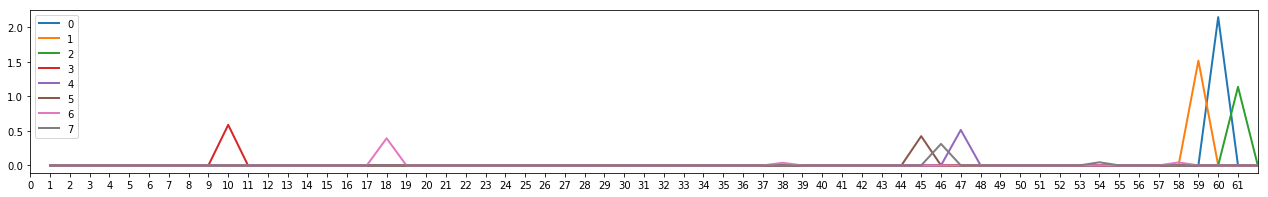

In [1375]:
plot_coef(W_61_8,save_fname='61days_frob_8comp_coef.png')

When compared with coefficients from NMF with 5 components, it seems like whne less number of components are specified, instead of combining features, NMF just push some additional components to be _noise_, and those days with strong but perhaps slightly weaker profiler echoes do not show up.

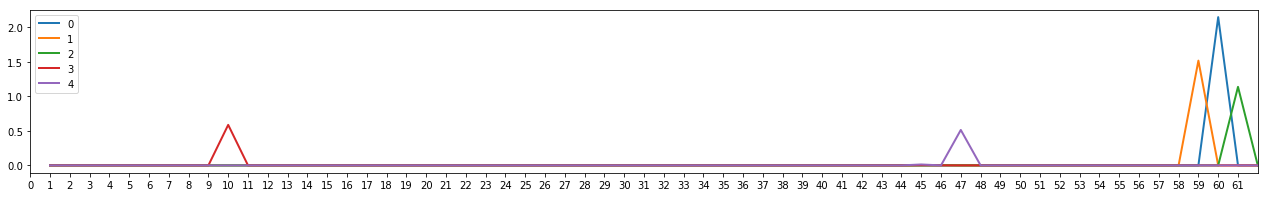

In [1379]:
plot_coef(W_61)

### Compare how the number of components impacts the reconstruction results

Below I compare how the original and reconstructed data are different for using 5-component or 8-component NMF.

For Day 18 where there is no peaked coefficient in 5-component NMF decomposition, the 8-component NMF does a lot better.

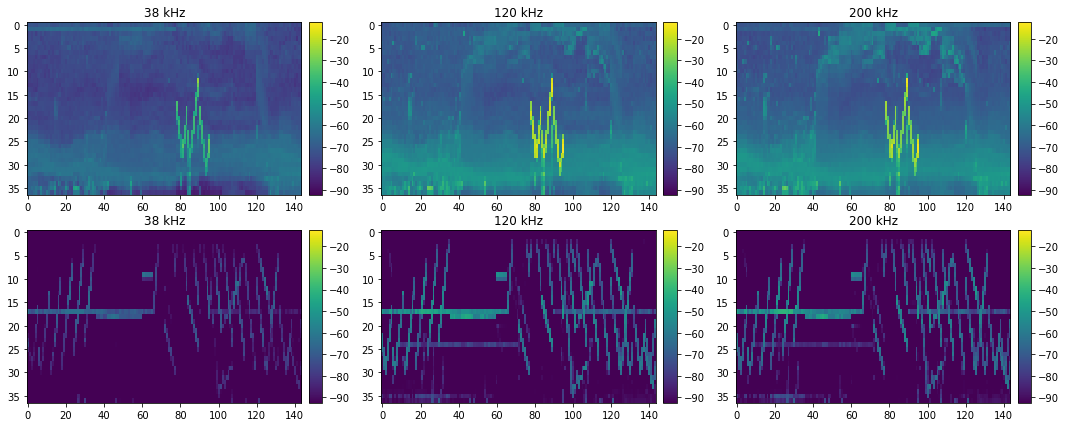

In [1382]:
dday = 18
plot_cmp_data_decomp(V=MVBS,X=D_61_plot,plot_day=dday,figsize_input=(18,7),save_fname='61days_frob_8comp_reconst%02d.png'%dday)

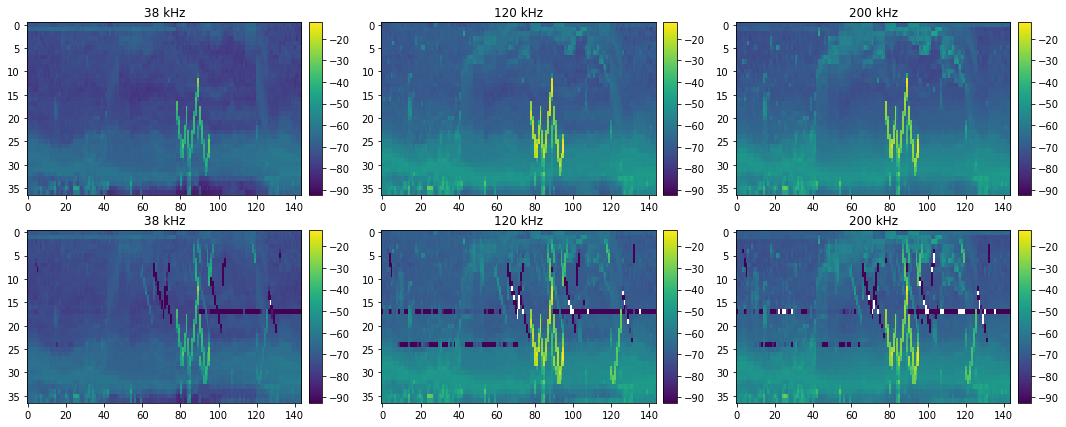

In [1383]:
dday = 18
plot_cmp_data_decomp(V=MVBS,X=D_61_8_plot,plot_day=dday,figsize_input=(18,7),save_fname='61days_frob_8comp_reconst%02d.png'%dday)

And again for Day 45 where there is no peaked coefficient in 5-component NMF decomposition, the 8-component NMF does a lot better.

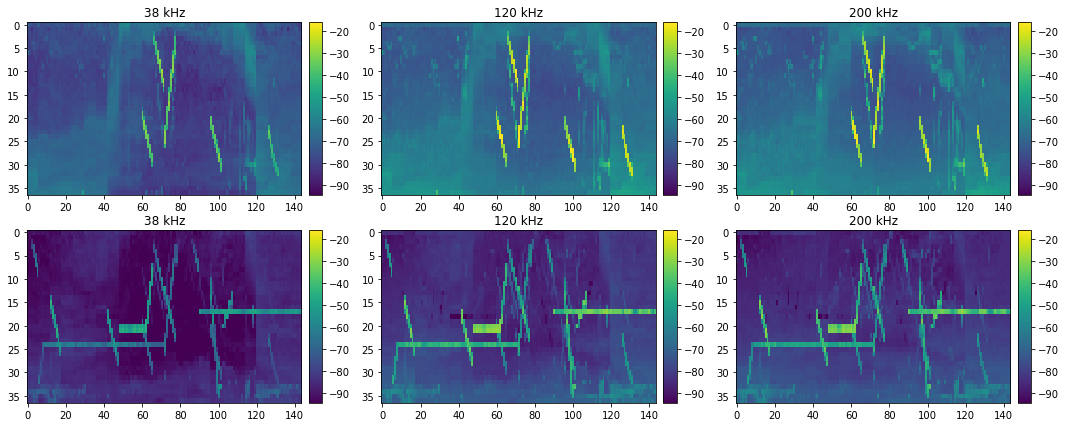

In [1384]:
dday = 45
plot_cmp_data_decomp(V=MVBS,X=D_61_plot,plot_day=dday,figsize_input=(18,7),save_fname='61days_frob_8comp_reconst%02d.png'%dday)

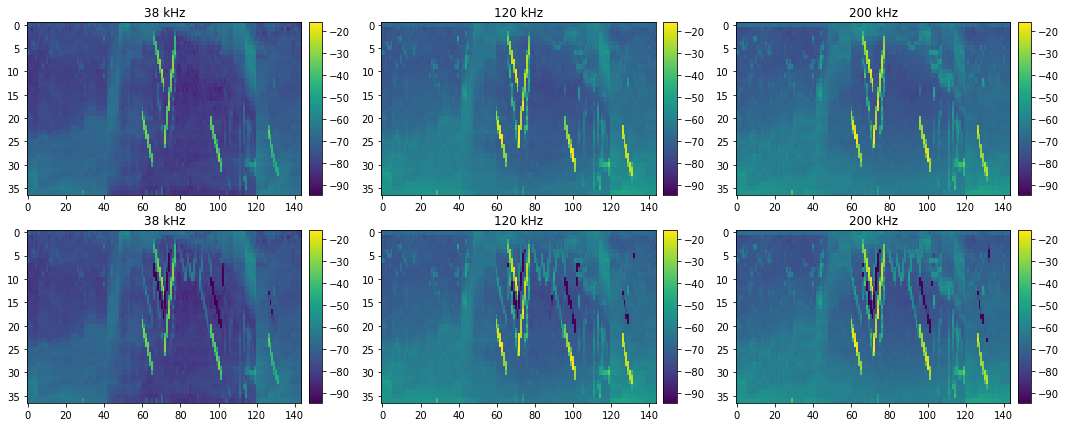

In [1385]:
dday = 45
plot_cmp_data_decomp(V=MVBS,X=D_61_8_plot,plot_day=dday,figsize_input=(18,7),save_fname='61days_frob_8comp_reconst%02d.png'%dday)

From the above comparison seems like it can be concluded that:

1. The profiler echoes were captured in the components as well as the _background_ animal echoes, but only the pattern in the day coincides with strong profiler echoes is captured. 
2. Reconstructions for days _without_ strong profiler echoes look _very bad_!

***********************************************
## Try tuning parameters in scikit-learn NMF

In [1387]:
mvbs = 10**(MVBS[:,1:-2,:]/10)
mvbs_3freq = np.array([mvbs[ff,:,:].T.reshape((-1,ping_per_day_mvbs*mvbs.shape[1])) for ff in range(3)])
mvbs_long = mvbs_3freq.swapaxes(0,1).reshape((-1,ping_per_day_mvbs*mvbs.shape[1]*3))

In [1398]:
n_comp = 8
nmf_61_al = decomposition.NMF(n_components=n_comp,alpha=100,l1_ratio=1)
W_61_al = nmf_61_al.fit_transform(mvbs_long)
H_61_al = nmf_61_al.components_
V_61_al = H_61_al.reshape((n_comp,3*ping_per_day_mvbs,-1)).swapaxes(1,2)

In [1399]:
D_61_al = nmf_61_al.inverse_transform(W_61_al).copy()
D_61_al_long = D_61_al.reshape((D_61_al.shape[0],-1,mvbs.shape[1])).swapaxes(1,2)
D_61_al_sep = D_61_al_long.reshape((D_61_al_long.shape[0],D_61_al_long.shape[1],-1,ping_per_day_mvbs)).transpose((2,0,1,3))
D_61_al_plot = 10*np.log10(D_61_al_sep.transpose((0,2,1,3))).reshape((D_61_al_sep.shape[0],D_61_al_sep.shape[2],-1))

/home/wu-jung/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log10


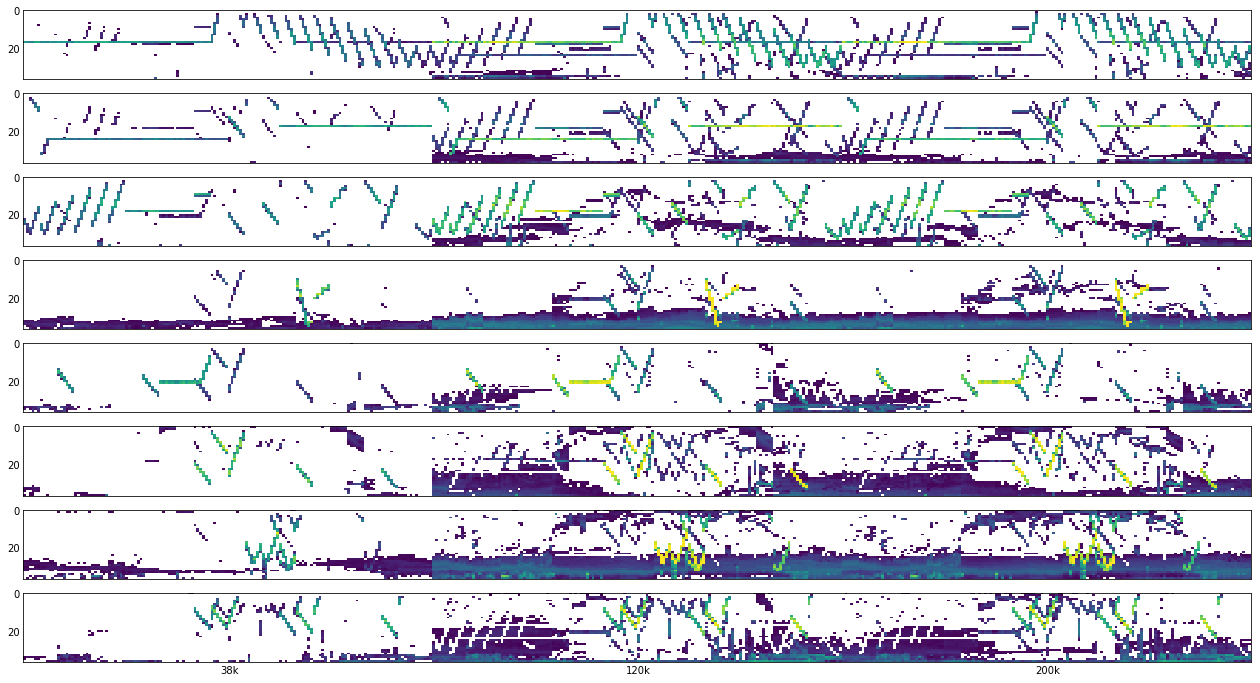

In [1400]:
plot_comp(V=V_61_al,figsize_input=(22,12),save_fname='61days_frob_8comp_alpha100.png')

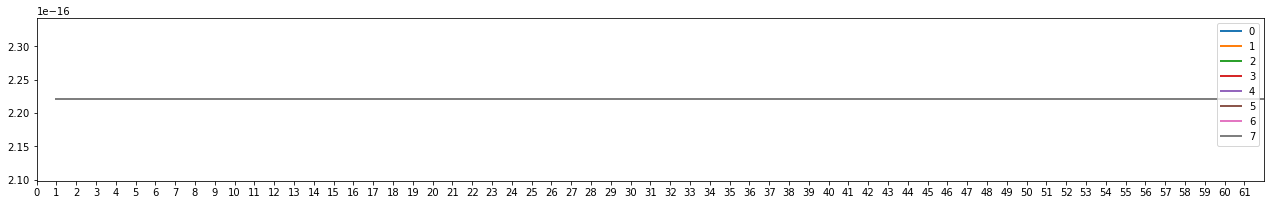

In [1401]:
plot_coef(W_61_al,save_fname='61days_frob_8comp_alpha100_coef.png')

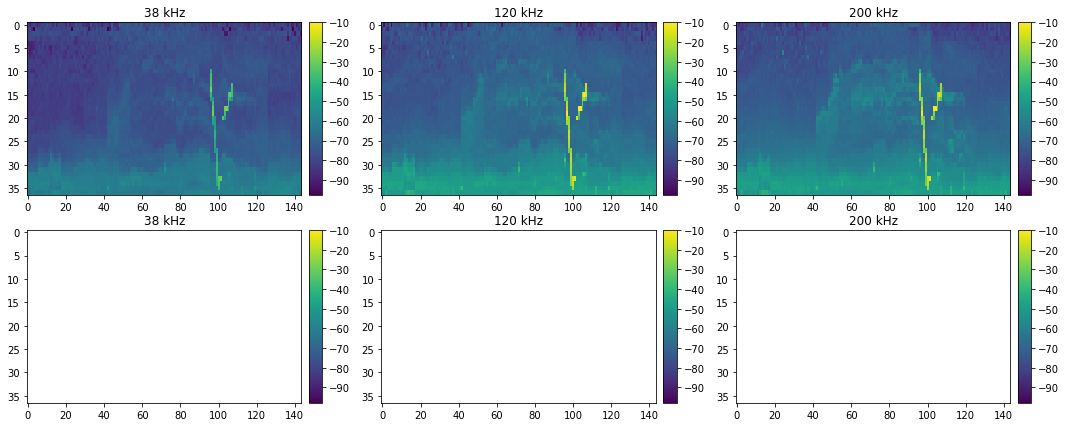

In [1403]:
dday = 10
plot_cmp_data_decomp(V=MVBS,X=D_61_al_plot,plot_day=dday,figsize_input=(18,7),\
                     save_fname='61days_frob_8comp_al_reconst%02d.png'%dday)

Pushing up the alpha value pushes everything into the regularization term... so compring the reconsutruction error, the error is nuch larger with high alpha value:

In [1405]:
(nmf_61_8.reconstruction_err_,nmf_61_al.reconstruction_err_)

(0.18023865301016756, 5.317474927355836)

In [1406]:
n_comp = 8
nmf_61_al_0 = decomposition.NMF(n_components=n_comp,alpha=100)
W_61_al_0 = nmf_61_al_0.fit_transform(mvbs_long)
H_61_al_0 = nmf_61_al_0.components_
V_61_al_0 = H_61_al_0.reshape((n_comp,3*ping_per_day_mvbs,-1)).swapaxes(1,2)

In [1407]:
D_61_al_0 = nmf_61_al_0.inverse_transform(W_61_al).copy()
D_61_al_0_long = D_61_al_0.reshape((D_61_al_0.shape[0],-1,mvbs.shape[1])).swapaxes(1,2)
D_61_al_0_sep = D_61_al_0_long.reshape((D_61_al_0_long.shape[0],D_61_al_0_long.shape[1],-1,ping_per_day_mvbs)).transpose((2,0,1,3))
D_61_al_0_plot = 10*np.log10(D_61_al_0_sep.transpose((0,2,1,3))).reshape((D_61_al_0_sep.shape[0],D_61_al_0_sep.shape[2],-1))

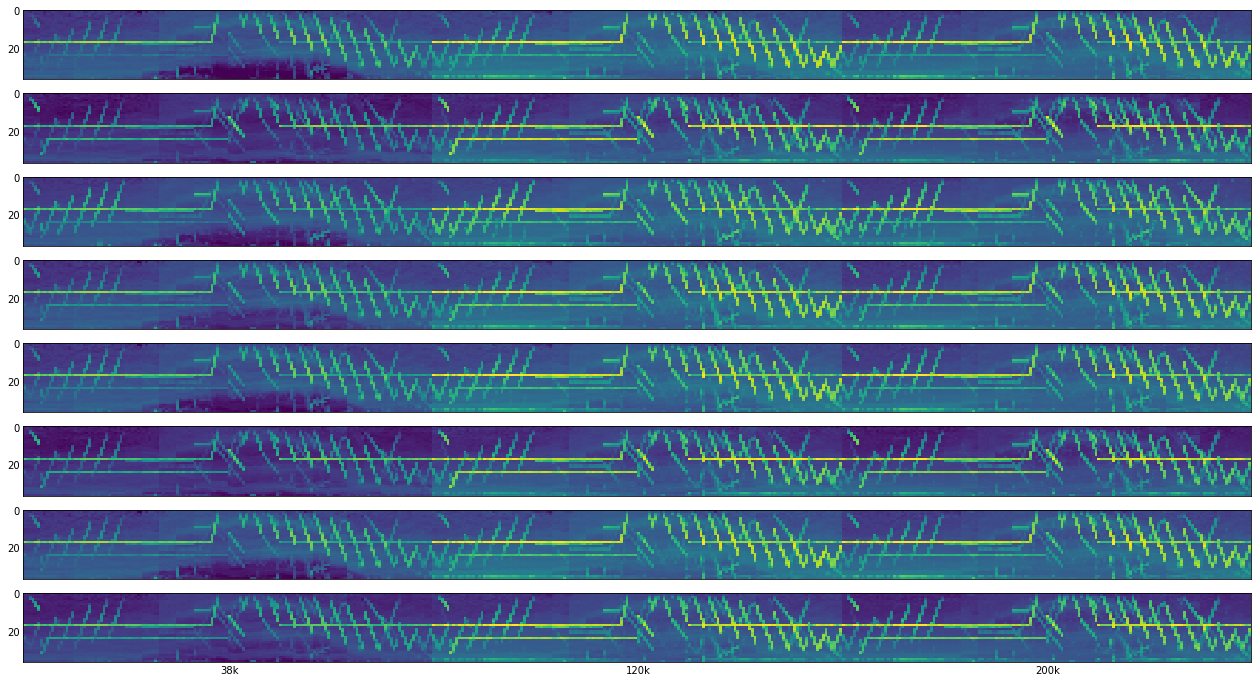

In [1408]:
plot_comp(V=V_61_al_0,figsize_input=(22,12),save_fname='61days_frob_8comp_alpha100_l10.png')

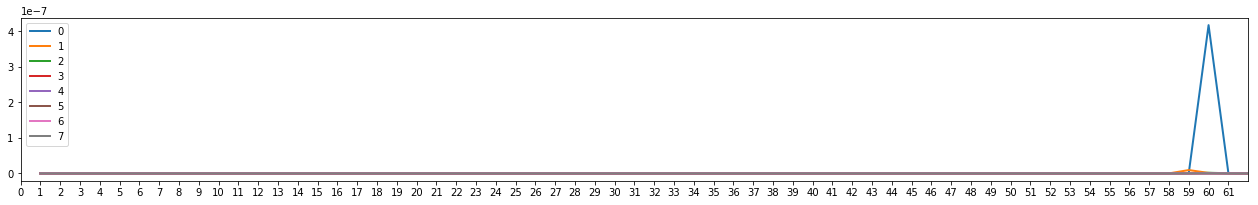

In [1409]:
plot_coef(W_61_al_0,save_fname='61days_frob_8comp_alpha100_l10_coef.png')

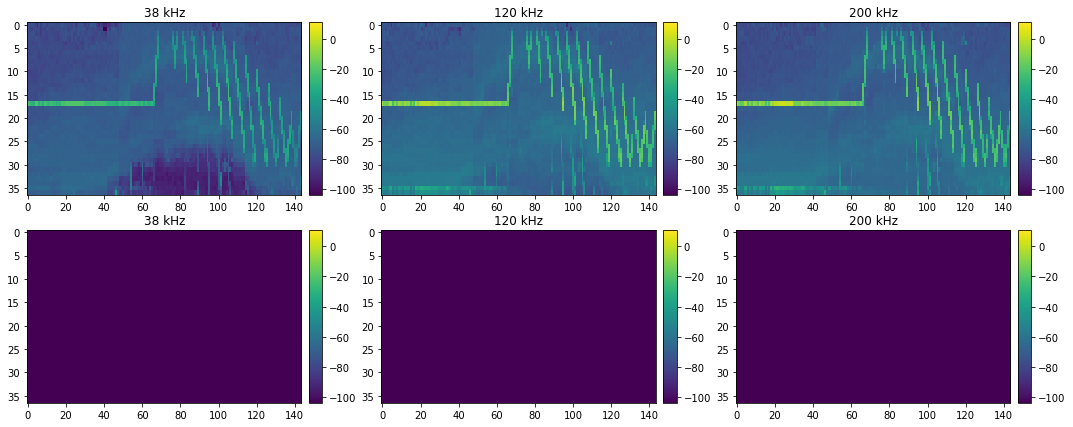

In [1411]:
dday = 60
plot_cmp_data_decomp(V=MVBS,X=D_61_al_0_plot,plot_day=dday,figsize_input=(18,7),\
                     save_fname='61days_frob_8comp_al_0_reconst%02d.png'%dday)

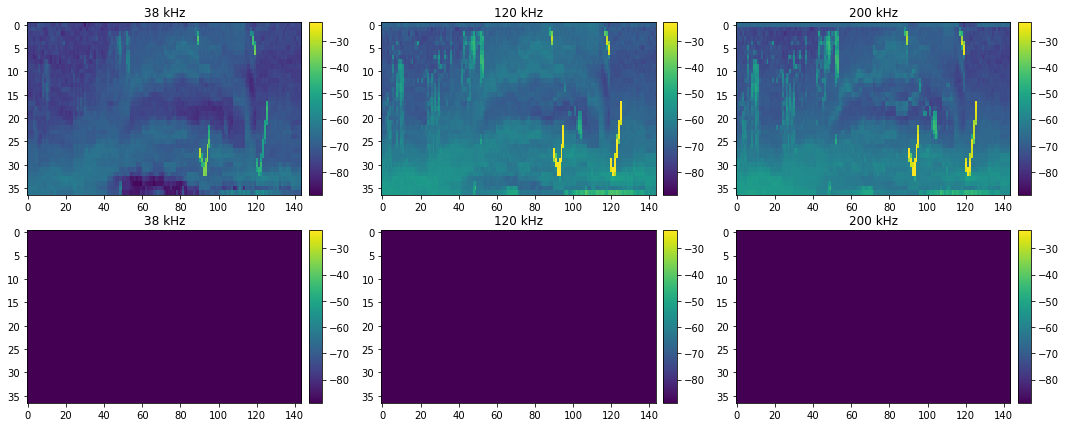

In [1412]:
dday = 58
plot_cmp_data_decomp(V=MVBS,X=D_61_al_0_plot,plot_day=dday,figsize_input=(18,7),\
                     save_fname='61days_frob_8comp_al_0_reconst%02d.png'%dday)

*******************************************
## PCA

In [1422]:
mvbs = 10**(MVBS[:,1:-2,:]/10)
mvbs_3freq = np.array([mvbs[ff,:,:].T.reshape((-1,ping_per_day_mvbs*mvbs.shape[1])) for ff in range(3)])
mvbs_long = mvbs_3freq.swapaxes(0,1).reshape((-1,ping_per_day_mvbs*mvbs.shape[1]*3))

n_comp = 8
pca = decomposition.PCA(n_components=n_comp)#,whiten=True)
pca.fit(mvbs_long)
W_pca = pca.fit_transform(mvbs_long)
H_pca = pca.components_
V_pca = H_pca.reshape((n_comp,3*ping_per_day_mvbs,-1)).swapaxes(1,2)

D_pca = pca.inverse_transform(W_pca).copy()
D_pca_long = D_pca.reshape((D_pca.shape[0],-1,mvbs.shape[1])).swapaxes(1,2)
D_pca_sep = D_pca_long.reshape((D_pca_long.shape[0],D_pca_long.shape[1],-1,ping_per_day_mvbs)).transpose((2,0,1,3))
D_pca_plot = 10*np.log10(D_pca_sep.transpose((0,2,1,3))).reshape((D_pca_sep.shape[0],D_pca_sep.shape[2],-1))

/home/wu-jung/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in log10


Below are all PCA components plotted in log scale. The missing values are resulted from log of negative values... Need to fix this in the plotting function... But we can see that the PCA is still capturing mostly the energy from the profiler echoes.

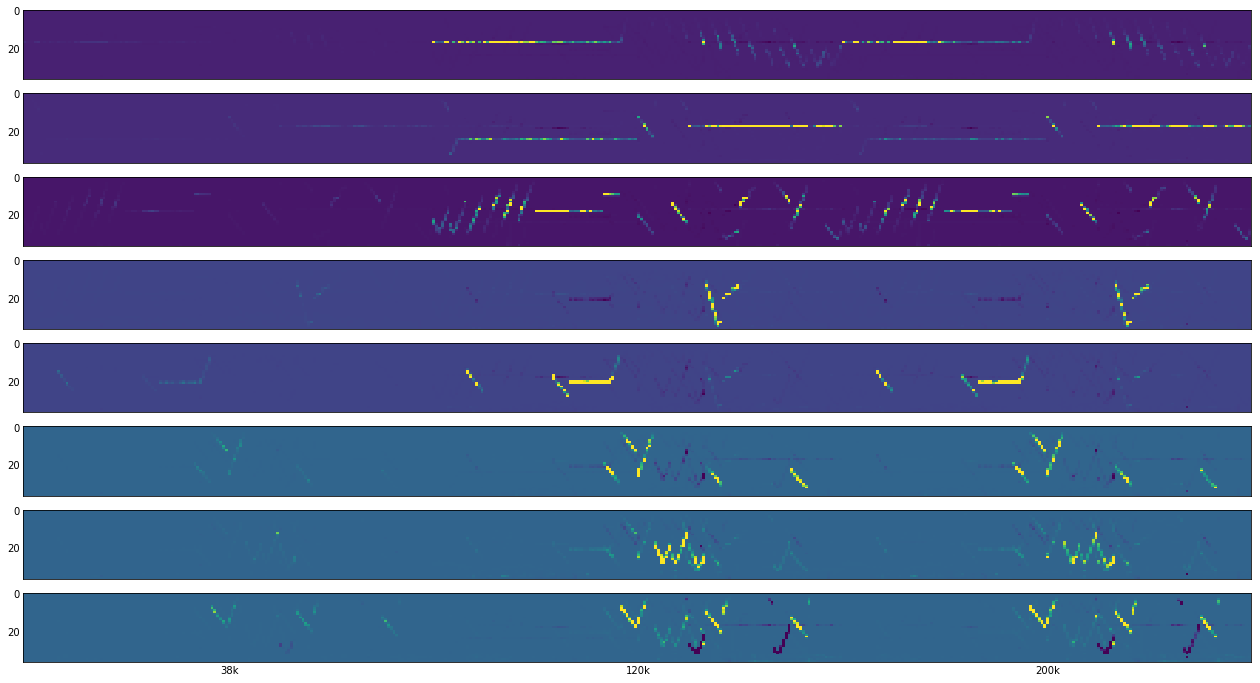

In [1447]:
plot_comp(V=V_pca,figsize_input=(22,12),save_fname='61days_pca_8comp.png',log_opt=0)

And the distribution of coefficients is similar to those from NMF.

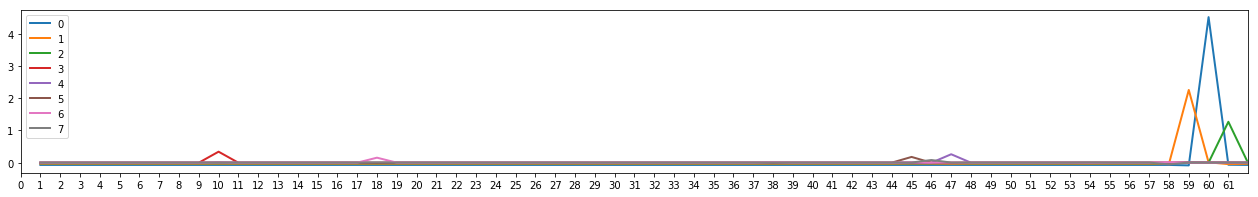

In [1424]:
plot_coef(W_pca,save_fname='61days_pca_8comp_coef.png')

But the reconstructions are notiably worse than NMF... Reconstruction is better for days with very high contribution of components (Day 59, Day 60), but degrades significantly for days with lower contribution of components (Day 10, Day 45), and very bad for days with nearly no contribution of components (Day 20, Day 30). And note how Day 20 and Day 30 are very similar to each other, which makes sense from the distributio of coefficients.

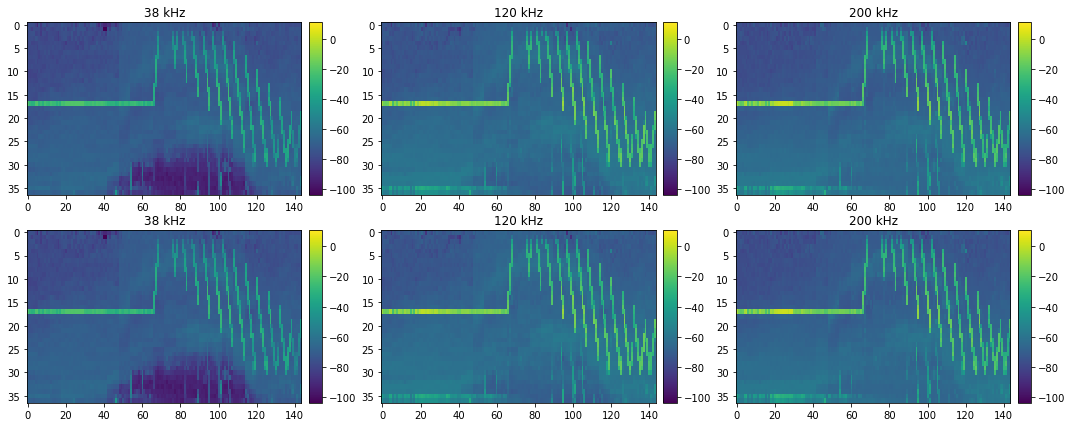

In [1425]:
dday = 60
plot_cmp_data_decomp(V=MVBS,X=D_pca_plot,plot_day=dday,figsize_input=(18,7),\
                     save_fname='61days_pca_8comp_reconst%02d.png'%dday,log_)

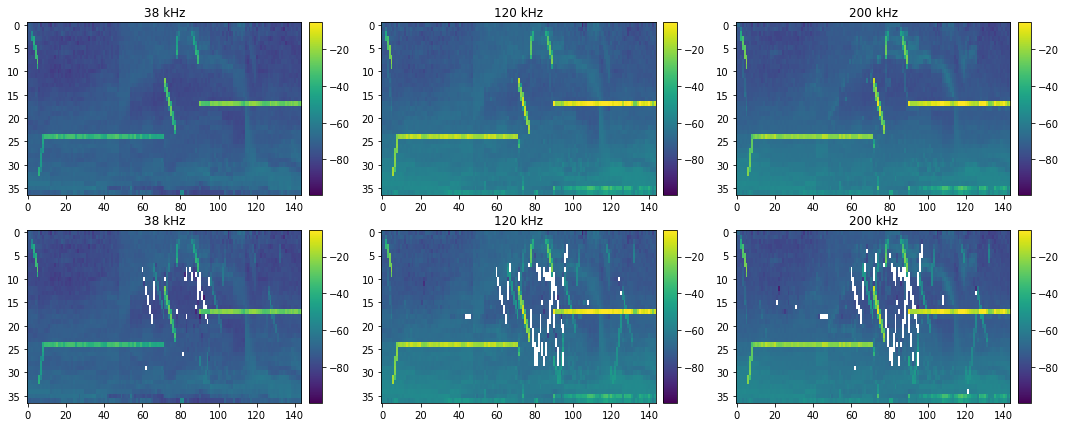

In [1427]:
dday = 59
plot_cmp_data_decomp(V=MVBS,X=D_pca_plot,plot_day=dday,figsize_input=(18,7),\
                     save_fname='61days_pca_8comp_reconst%02d.png'%dday)

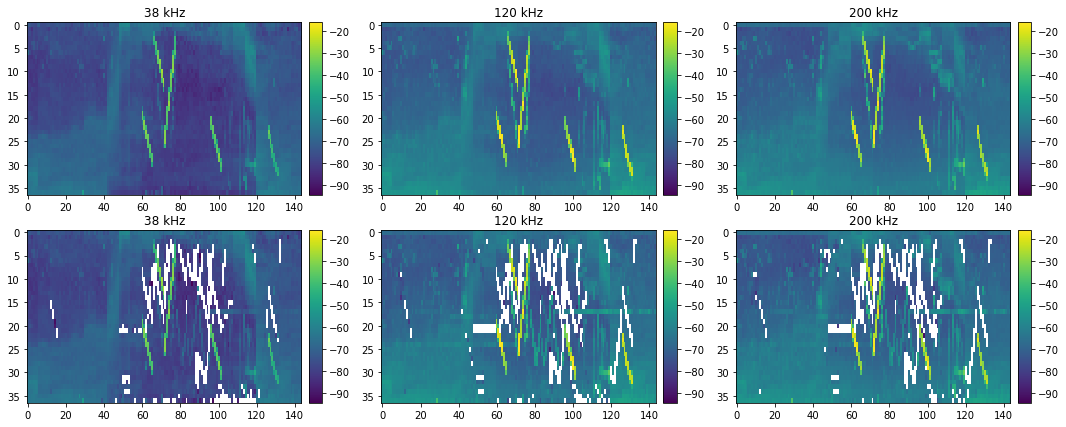

In [1428]:
dday = 45
plot_cmp_data_decomp(V=MVBS,X=D_pca_plot,plot_day=dday,figsize_input=(18,7),\
                     save_fname='61days_pca_8comp_reconst%02d.png'%dday)

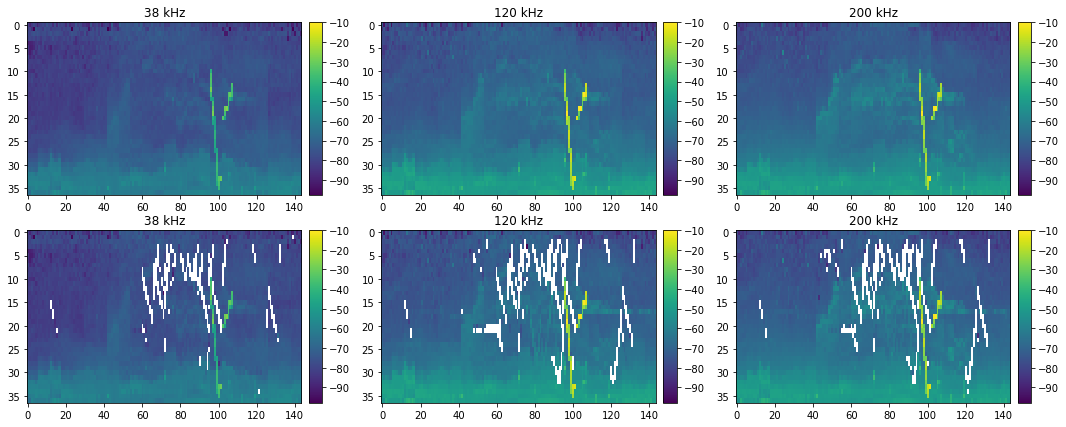

In [1429]:
dday = 10
plot_cmp_data_decomp(V=MVBS,X=D_pca_plot,plot_day=dday,figsize_input=(18,7),\
                     save_fname='61days_pca_8comp_reconst%02d.png'%dday)

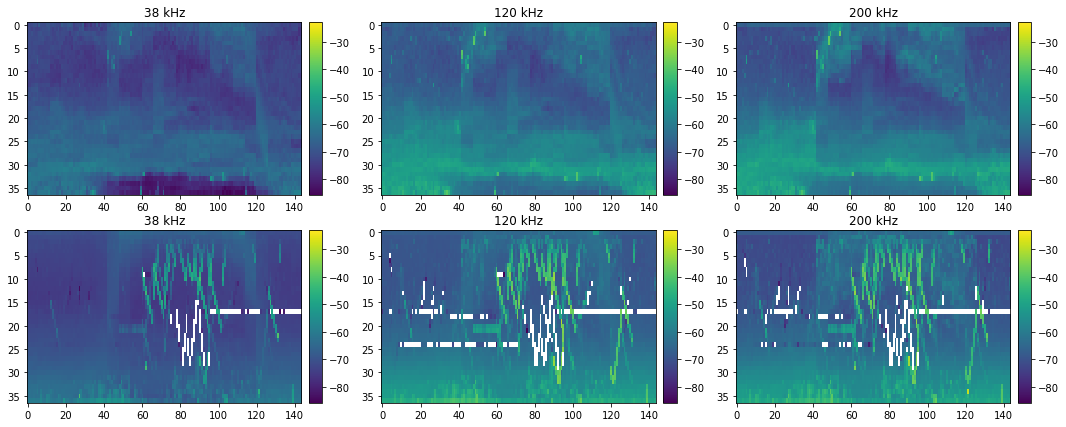

In [1430]:
dday = 20
plot_cmp_data_decomp(V=MVBS,X=D_pca_plot,plot_day=dday,figsize_input=(18,7),\
                     save_fname='61days_pca_8comp_reconst%02d.png'%dday)

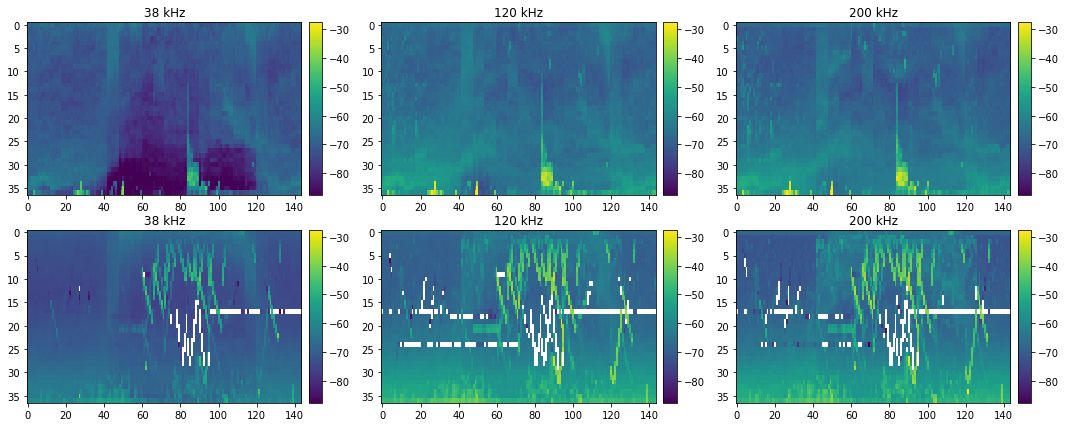

In [1431]:
dday = 30
plot_cmp_data_decomp(V=MVBS,X=D_pca_plot,plot_day=dday,figsize_input=(18,7),\
                     save_fname='61days_pca_8comp_reconst%02d.png'%dday)

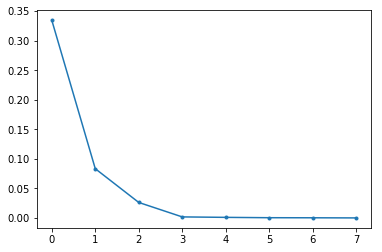

In [1421]:
plt.plot(pca.explained_variance_,'.-')

****************************************
## Decomposition in the log domain

In [1448]:
MVBS_copy = np.copy(MVBS[:,1:-2,:-3*ping_per_day_mvbs])
MVBS_3freq = np.array([MVBS_copy[ff,:,:].T.reshape((-1,ping_per_day_mvbs*MVBS_copy.shape[1])) for ff in range(3)])
MVBS_long = MVBS_3freq.swapaxes(0,1).reshape((-1,ping_per_day_mvbs*MVBS_copy.shape[1]*3))

n_comp = 8
pca_LOG = decomposition.PCA(n_components=n_comp)#,whiten=True)
pca_LOG.fit(MVBS_long)
W_pca_LOG = pca_LOG.fit_transform(MVBS_long)
H_pca_LOG = pca_LOG.components_
V_pca_LOG = H_pca_LOG.reshape((n_comp,3*ping_per_day_mvbs,-1)).swapaxes(1,2)

D_pca_LOG = pca.inverse_transform(W_pca_LOG).copy()
D_pca_LOG_sep,D_pca_LOG_plot = separate_transform(D_pca_LOG,MVBS_copy,log_opt=0)

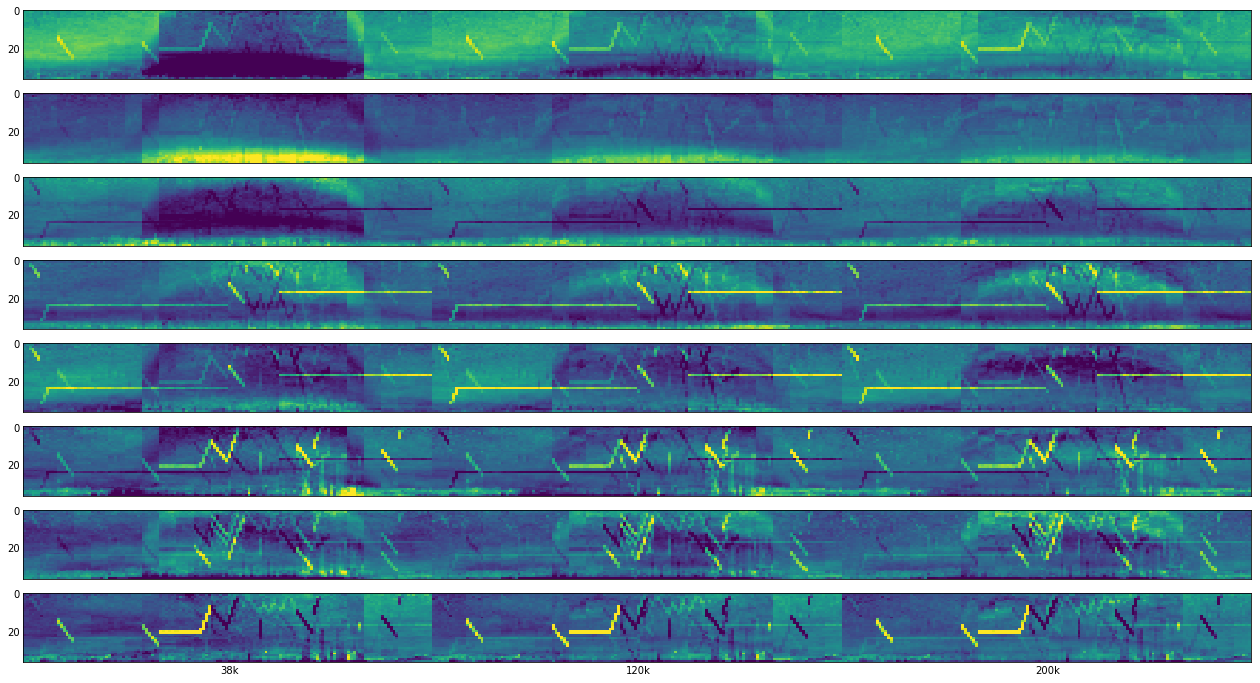

In [1449]:
plot_comp(V=V_pca_LOG,figsize_input=(22,12),save_fname='61days_pca_LOG_8comp.png',log_opt=0)

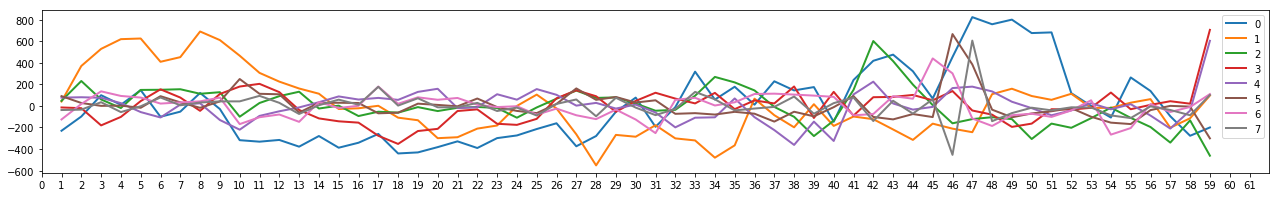

In [1450]:
plot_coef(W_pca_LOG,save_fname='61days_pca_LOG_8comp.png')

In [1452]:
D_pca_LOG_sep.shape

(3, 59, 37, 144)

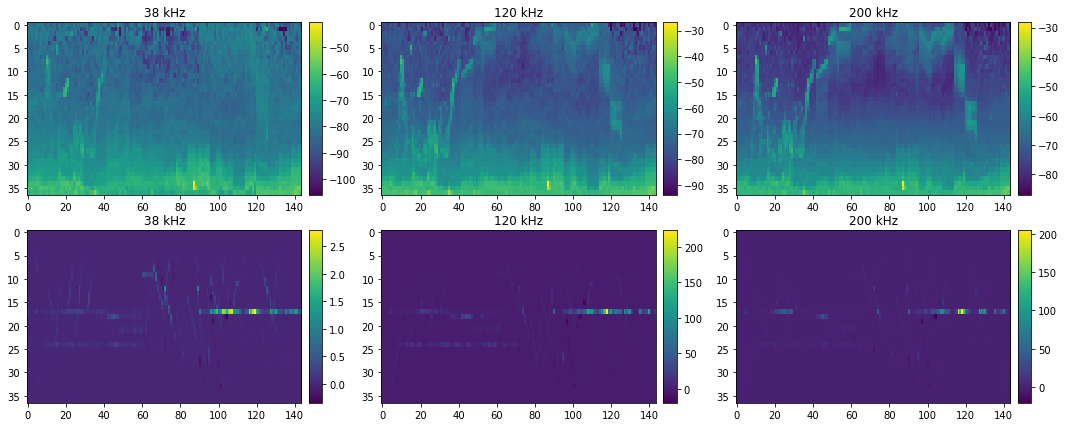

In [1462]:
dday = 8
plot_cmp_data_decomp(V=MVBS,X=D_pca_LOG_plot,plot_day=dday,figsize_input=(18,7),\
                     save_fname='61days_pca_LOG_8comp_reconst%02d.png'%dday,same_cax_opt=0)

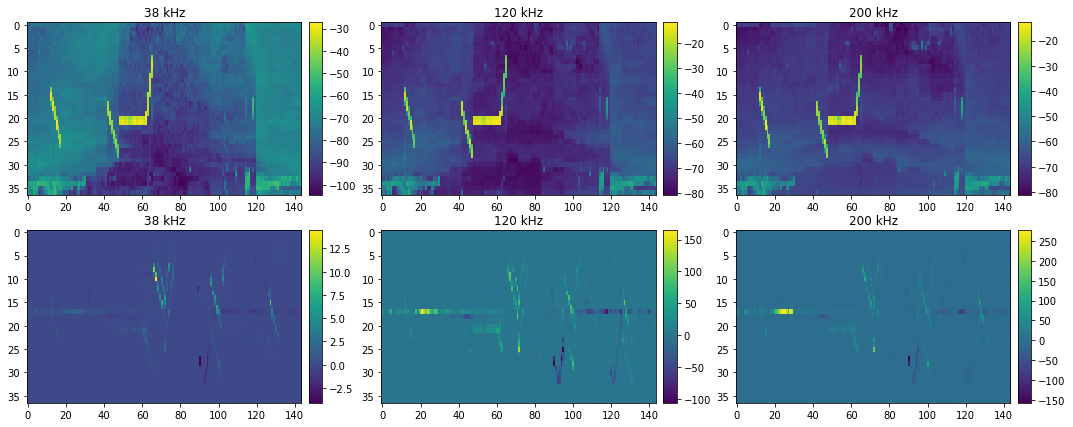

In [1461]:
dday = 47
plot_cmp_data_decomp(V=MVBS,X=D_pca_LOG_plot,plot_day=dday,figsize_input=(18,7),\
                     save_fname='61days_pca_LOG_8comp_reconst%02d.png'%dday,same_cax_opt=0)

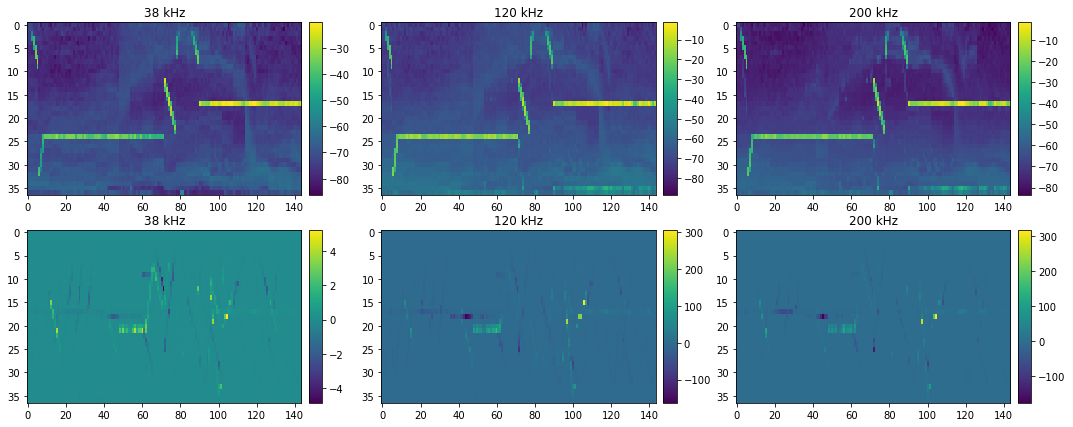

In [1463]:
dday = 59
plot_cmp_data_decomp(V=MVBS,X=D_pca_LOG_plot,plot_day=dday,figsize_input=(18,7),\
                     save_fname='61days_pca_LOG_8comp_reconst%02d.png'%dday,same_cax_opt=0)

****************************************
## Some random samples of daily echograms

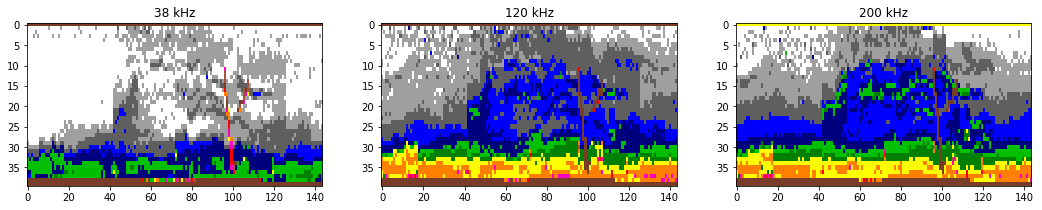

In [814]:
plot_single_day(9)

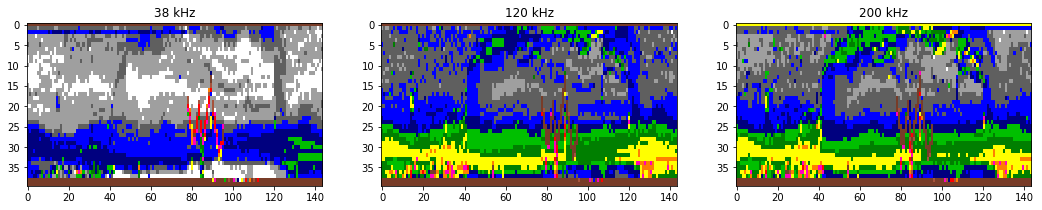

In [815]:
plot_single_day(17)

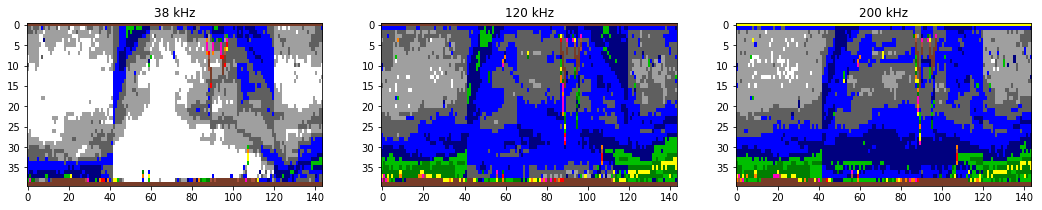

In [822]:
plot_single_day(37)

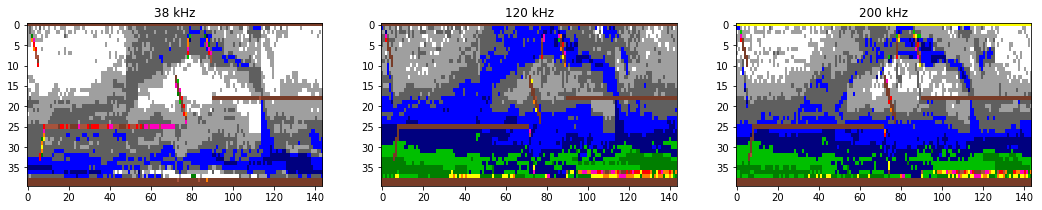

In [816]:
plot_single_day(58)

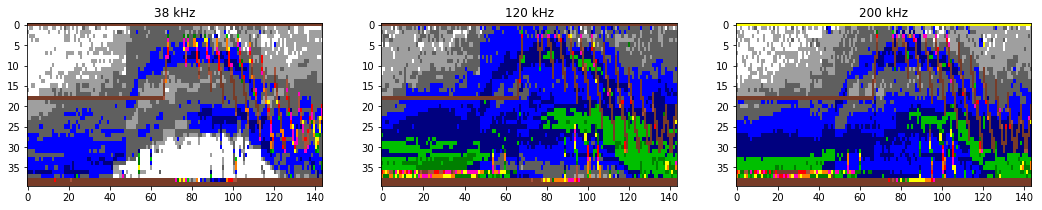

In [817]:
plot_single_day(59)

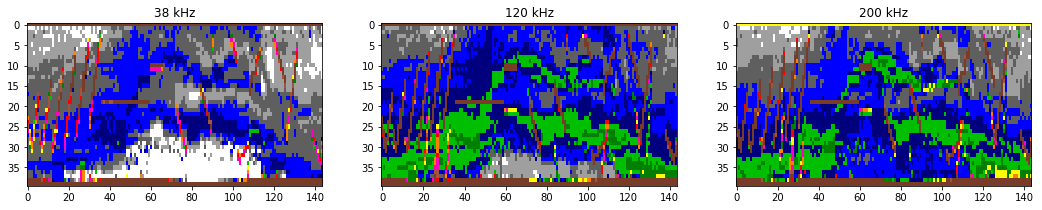

In [818]:
plot_single_day(60)

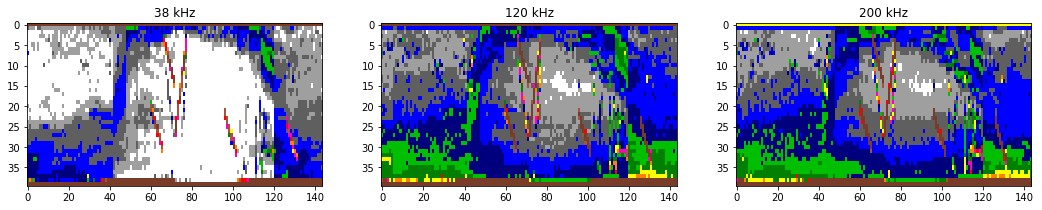

In [848]:
plot_single_day(44)

In [928]:
n_comp = 5
nmf_min = decomposition.NMF(n_components=n_comp,l1_ratio=1,alpha=10)
W_nmf = nmf_min.fit_transform(mvbs_long)
H_nmf = nmf_min.components_
V_nmf = H_nmf.reshape((n_comp,3*ping_per_day_mvbs,-1)).swapaxes(1,2)

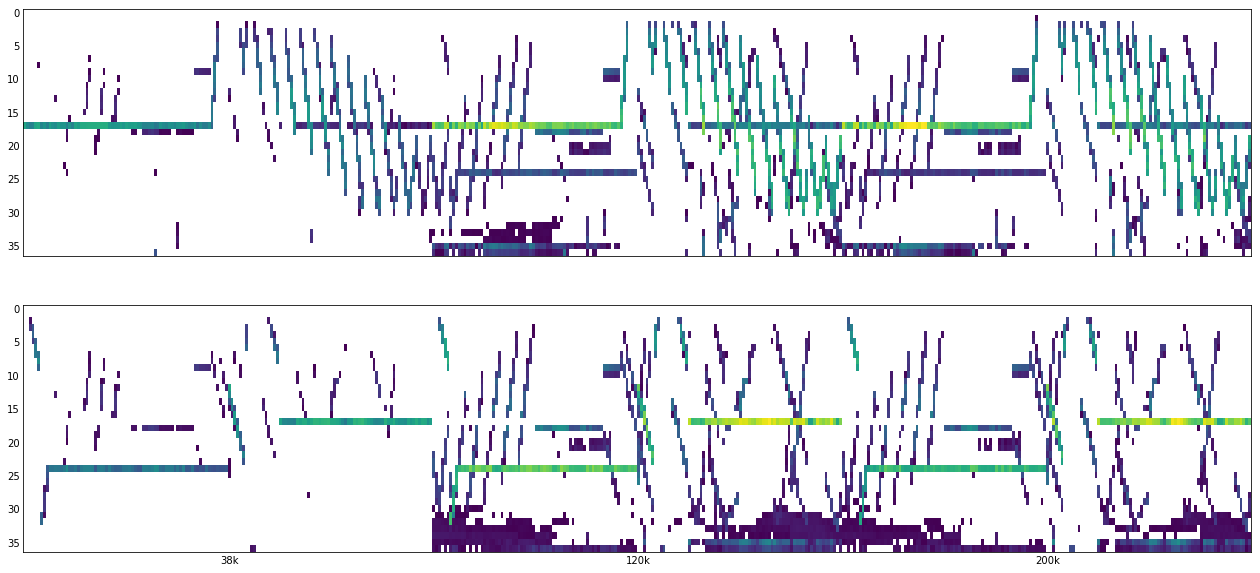

In [929]:
plot_comp(figsize_input=(22,10),save_fname='all_days_2comp.png')

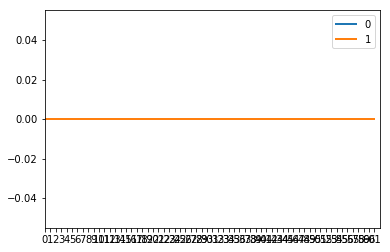

In [930]:
labels = [str(x) for x in range(n_comp)]
for w, label in zip(W_nmf.T, labels):
    plt.plot(w, label=label,linewidth=2)
plt.legend()
plt.xticks(range(mvbs_long.shape[0]))
# plt.yscale('log')
plt.xlim([0,mvbs_long.shape[0]])
# plt.savefig(os.path.join(save_path,save_fname))
plt.show()

In [959]:
n_comp = 15
pca = decomposition.PCA(n_components=n_comp)#,whiten=True)
pca.fit(mvbs_long)
W_nmf = pca.fit_transform(mvbs_long)
H_nmf = pca.components_
V_nmf = H_nmf.reshape((n_comp,3*ping_per_day_mvbs,-1)).swapaxes(1,2)

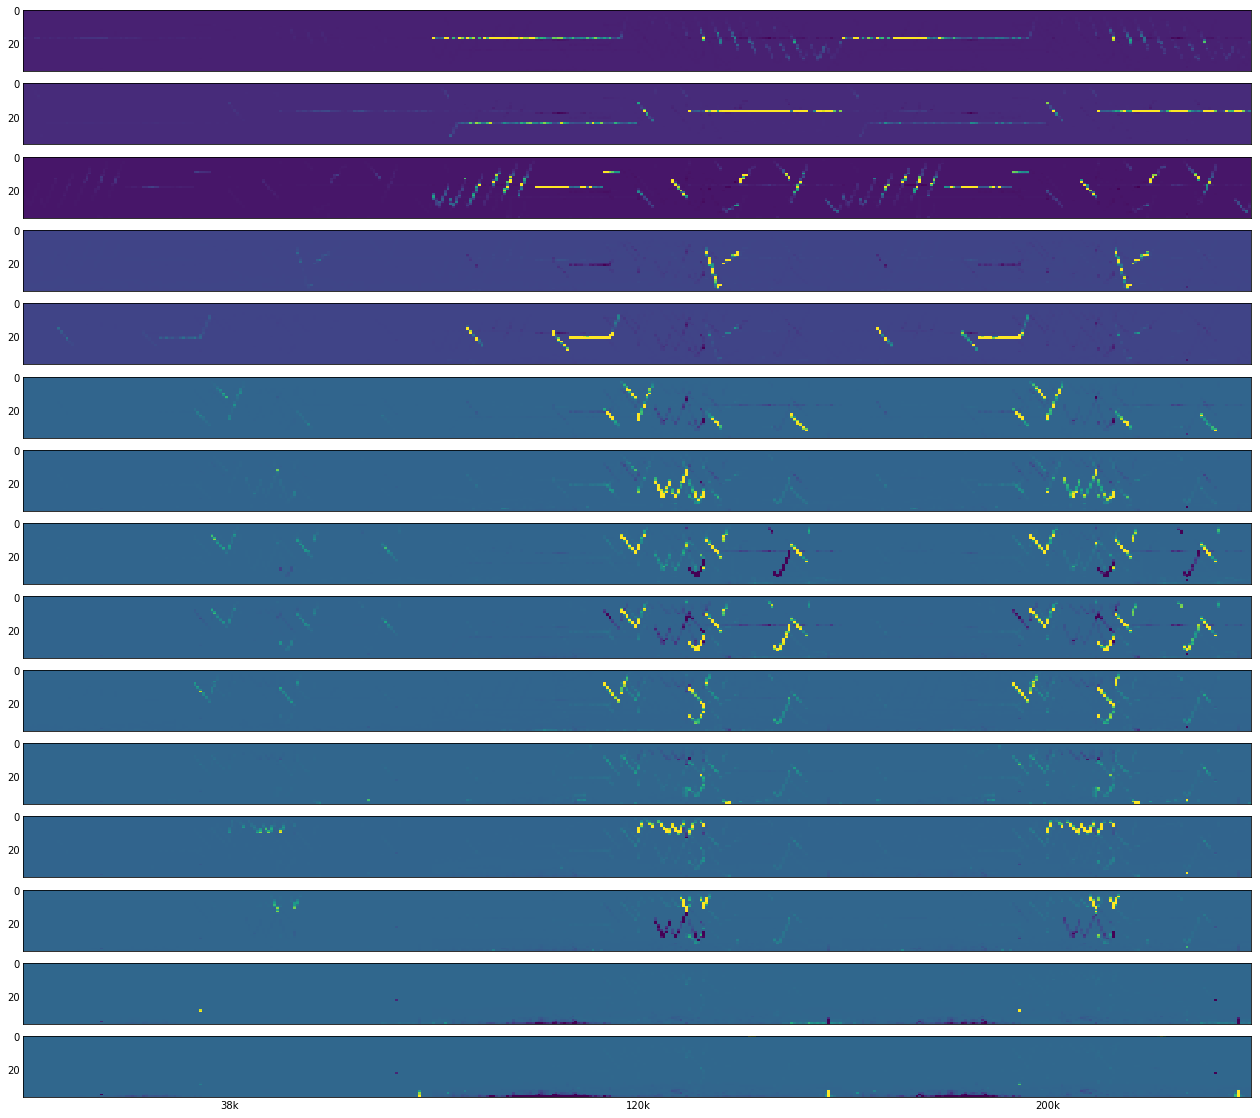

In [960]:
fig,ax=plt.subplots(n_comp,1,sharex=True,figsize=(22,20))
for c in range(n_comp):
#     vlog = 10*np.ma.log10(V_nmf[c,:,:])
    vlog = V_nmf[c,:,:]
    cmean = np.mean(vlog)
    cstd = np.std(vlog)
    cmin = max((np.min(vlog),cmean-2*cstd))
    cmax = min((np.max(vlog),cmean+4*cstd))
    ax[c].imshow(vlog,aspect='auto',vmin=cmin,vmax=cmax)
#     ax[c].imshow(V_nmf[c,:,:],aspect='auto')#,vmin=cmin,vmax=cmax)
    ax[c].set_xticks([x*ping_per_day_mvbs+ping_per_day_mvbs/2 for x in range(3)])
    ax[c].set_xticklabels(['38k','120k','200k'])
    ax[c].tick_params('both', length=0)

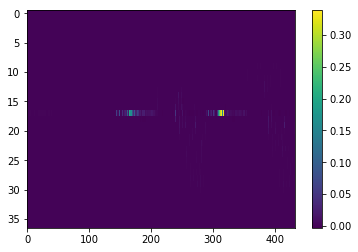

In [951]:
plt.imshow(V_nmf[0,:,:],aspect='auto')
plt.colorbar()

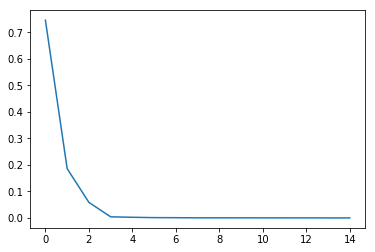

In [962]:
plt.plot(pca.explained_variance_ratio_)

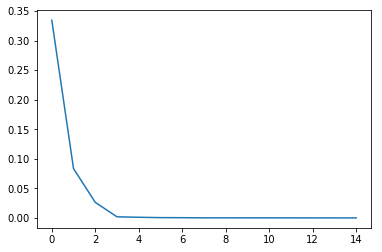

In [965]:
plt.plot(pca.explained_variance_)

AttributeError: 'module' object has no attribute 'figsize'

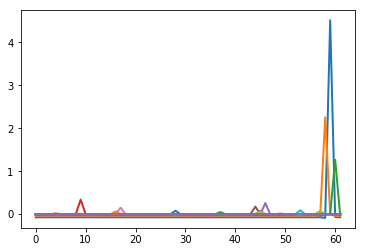

In [947]:
labels = [str(x) for x in range(n_comp)]
for w, label in zip(W_nmf.T, labels):
    plt.plot(w, label=label,linewidth=2)
plt.figsize((22,3))
plt.legend()
plt.xticks(range(mvbs_long.shape[0]))
plt.xlim([0,mvbs_long.shape[0]])
plt.show()

***************************************************
## NMF in the log domain

The decomposition seems to be more dominated by echoes from biological sources when running NMF in the log domain. This seems to be because the differences between the very high energy (profiler) and low energy (biological sources) parts are much smaller in the log-transformed data?

I again tested how the decomposition would change depending on if or not the last 3 days of data are included in the data for decomposition.

### *Not* include data from the last 3 days

In [966]:
MVBS_copy = np.copy(MVBS[:,1:-2,:-3*ping_per_day_mvbs])
MVBS_3freq = np.array([MVBS_copy[ff,:,:].T.reshape((-1,ping_per_day_mvbs*MVBS_copy.shape[1])) for ff in range(3)])
MVBS_long = MVBS_3freq.swapaxes(0,1).reshape((-1,ping_per_day_mvbs*MVBS_copy.shape[1]*3))

In [972]:
n_comp = 3
pca_log = decomposition.PCA(n_components=n_comp)#,whiten=True)
pca_log.fit(MVBS_long)
W_pca = pca_log.fit_transform(MVBS_long)
H_pca = pca_log.components_
V_pca = H_pca.reshape((n_comp,3*ping_per_day_mvbs,-1)).swapaxes(1,2)

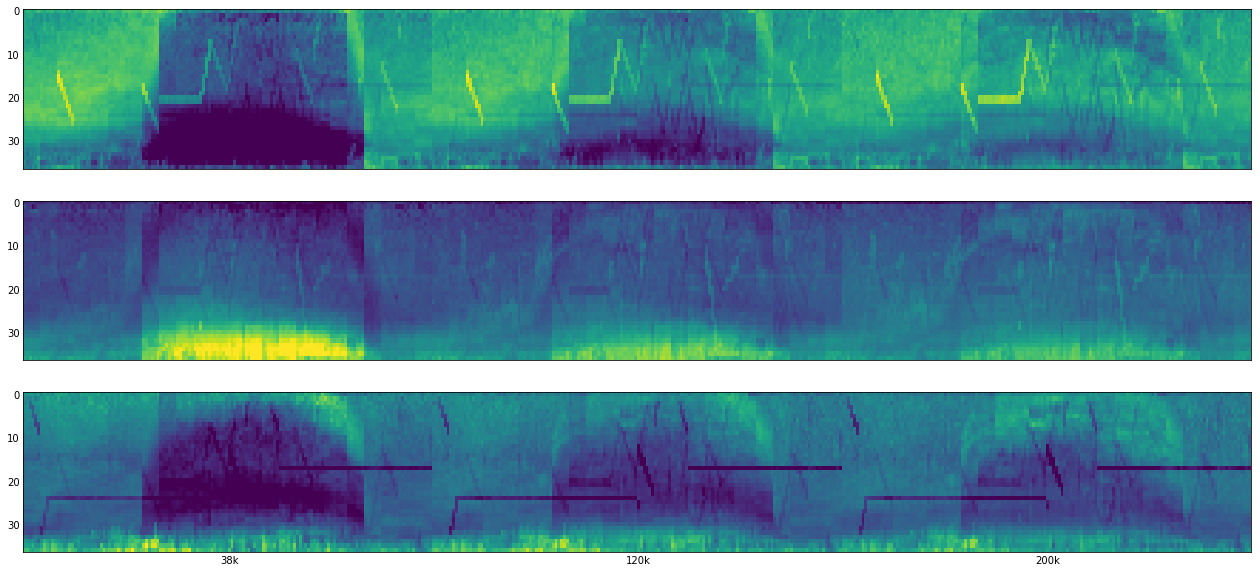

In [978]:
fig,ax=plt.subplots(n_comp,1,sharex=True,figsize=(22,10))
for c in range(n_comp):
#     vlog = 10*np.ma.log10(V_nmf[c,:,:])
    vlog = V_pca[c,:,:]
    cmean = np.mean(vlog)
    cstd = np.std(vlog)
    cmin = max((np.min(vlog),cmean-2*cstd))
    cmax = min((np.max(vlog),cmean+4*cstd))
    ax[c].imshow(vlog,aspect='auto',vmin=cmin,vmax=cmax)
#     ax[c].imshow(V_nmf[c,:,:],aspect='auto')#,vmin=cmin,vmax=cmax)
    ax[c].set_xticks([x*ping_per_day_mvbs+ping_per_day_mvbs/2 for x in range(3)])
    ax[c].set_xticklabels(['38k','120k','200k'])
    ax[c].tick_params('both', length=0)

In [975]:
n_comp = 3
M_nmf_min = decomposition.NMF(n_components=n_comp)
M_W_nmf = M_nmf_min.fit_transform(MVBS_long-MVBS_long.min())
M_H_nmf = M_nmf_min.components_
M_V_nmf = M_H_nmf.reshape((n_comp,3*ping_per_day_mvbs,-1)).swapaxes(1,2)

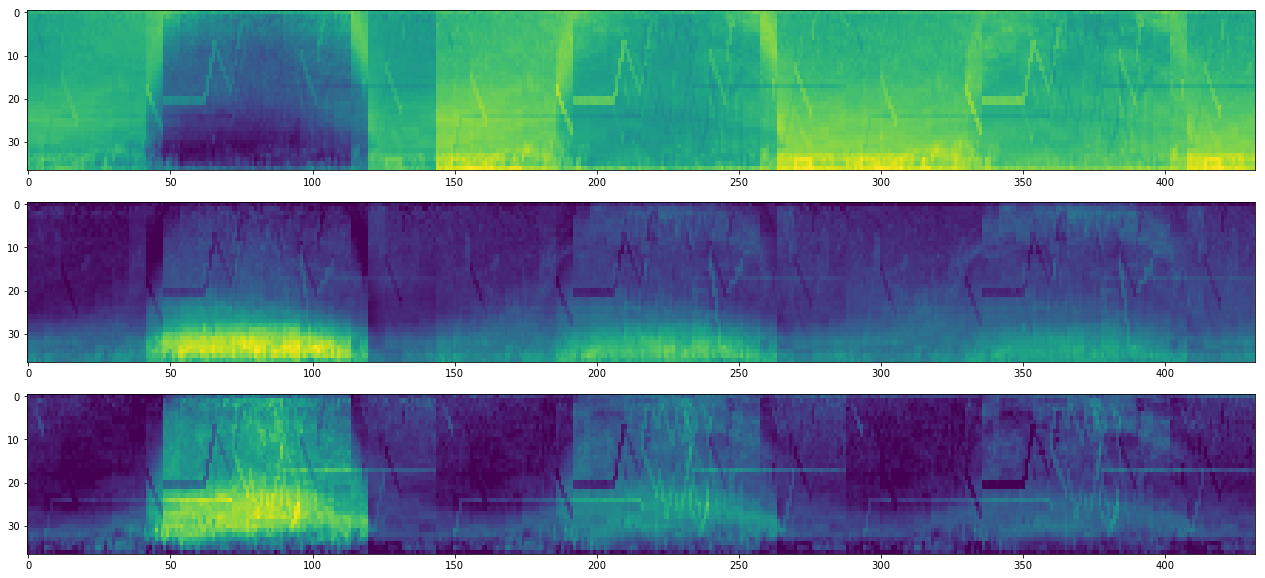

In [977]:
fig,ax=plt.subplots(3,1,sharey=True,figsize=(22,10))
for c in range(n_comp):
    ax[c].imshow(M_V_nmf[c,:,:],aspect='auto')

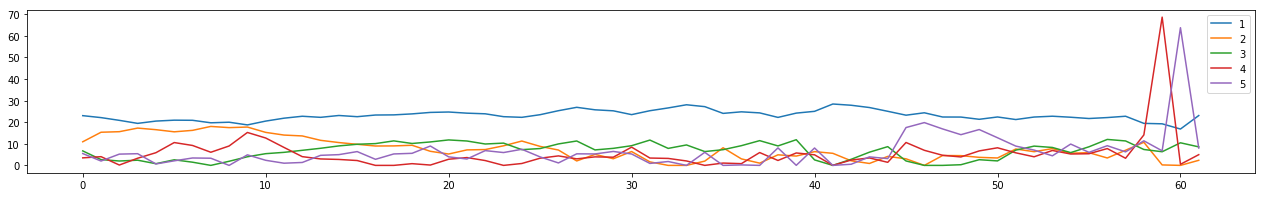

In [572]:
plt.figure(figsize=(22,3))
labels =['1', '2', '3','4','5']
for w, label in zip(M_W_nmf.T, labels):
    plt.plot(w, label=label)
plt.legend()

### Include data from all days

In [573]:
MVBS_copy = np.copy(MVBS[:,1:-2,:])
MVBS_3freq = np.array([MVBS_copy[ff,:,:].T.reshape((-1,ping_per_day_mvbs*MVBS_copy.shape[1])) for ff in range(3)])
MVBS_long = MVBS_3freq.swapaxes(0,1).reshape((-1,ping_per_day_mvbs*MVBS_copy.shape[1]*3))

In [574]:
n_comp = 5
M_nmf_min = decomposition.NMF(n_components=n_comp)
M_W_nmf = M_nmf_min.fit_transform(MVBS_long-MVBS_long.min())
M_H_nmf = M_nmf_min.components_
M_V_nmf = M_H_nmf.reshape((5,3*ping_per_day_mvbs,-1)).swapaxes(1,2)

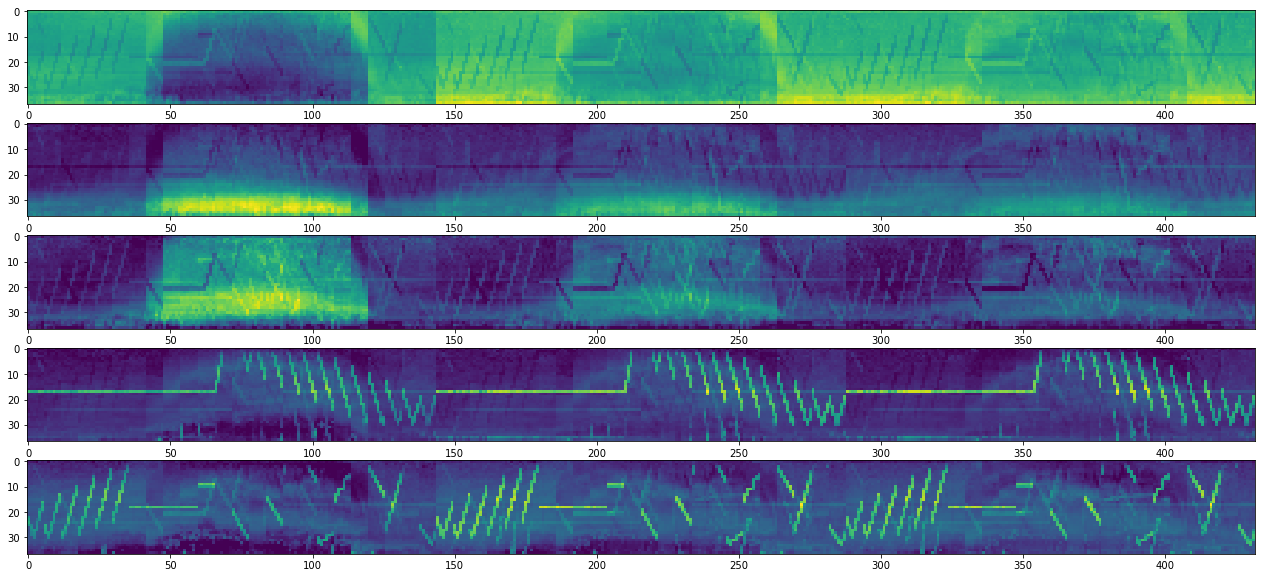

In [575]:
fig,ax=plt.subplots(5,1,sharey=True,figsize=(22,10))
for c in range(n_comp):
    ax[c].imshow(M_V_nmf[c,:,:],aspect='auto')

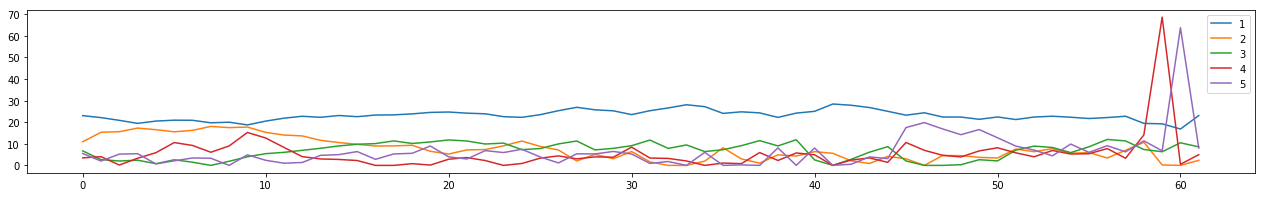

In [576]:
plt.figure(figsize=(22,3))
labels =['1', '2', '3','4','5']
for w, label in zip(M_W_nmf.T, labels):
    plt.plot(w, label=label)
plt.legend()

***************************************************
## Freq-differencing

In [579]:
Sv_1 = MVBS[2,:,:]
Sv_2 = MVBS[0,:,:]

yes_1 = ~np.isnan(Sv_1)
yes_2 = ~np.isnan(Sv_2)
Sv_diff_12 = Sv_1 - Sv_2
Sv_diff_12[yes_1 & ~yes_2] = np.inf
Sv_diff_12[~yes_1 & yes_2] = -np.inf

idx_fish = (np.isneginf(Sv_diff_12) | (Sv_diff_12<-2)) & (Sv_diff_12>-16)
idx_fish_2 = (np.isneginf(Sv_diff_12) | (Sv_diff_12<-2))
idx_zoop = np.isposinf(Sv_diff_12) | (Sv_diff_12>-2)
idx_other = Sv_diff_12<-16

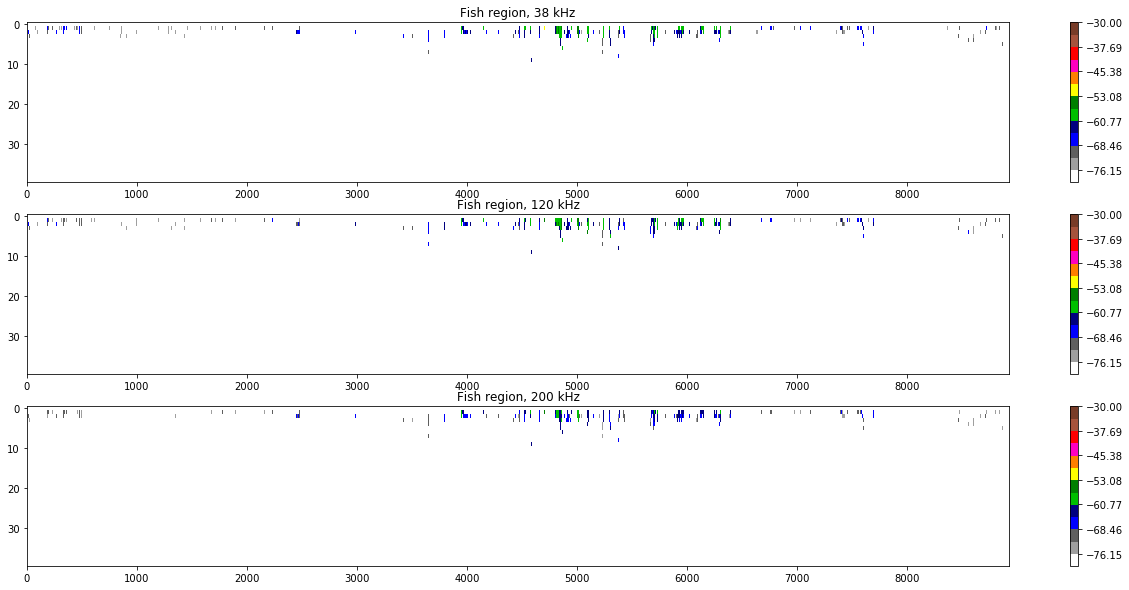

In [603]:
fig,(ax0,ax1,ax2) = plt.subplots(3,1,figsize=(22,10))
im0 = ax0.imshow(np.ma.masked_where(~idx_fish,MVBS[0,:,:]),aspect='auto',cmap=e_cmap,norm=e_norm)
fig.colorbar(im0,ax=ax0)
ax0.set_title('Fish region, 38 kHz')
im1 = ax1.imshow(np.ma.masked_where(~idx_fish,MVBS[1,:,:]),aspect='auto',cmap=e_cmap,norm=e_norm)
fig.colorbar(im1,ax=ax1)
ax1.set_title('Fish region, 120 kHz')
im2 = ax2.imshow(np.ma.masked_where(~idx_fish,MVBS[2,:,:]),aspect='auto',cmap=e_cmap,norm=e_norm)
fig.colorbar(im2,ax=ax2)
ax2.set_title('Fish region, 200 kHz')

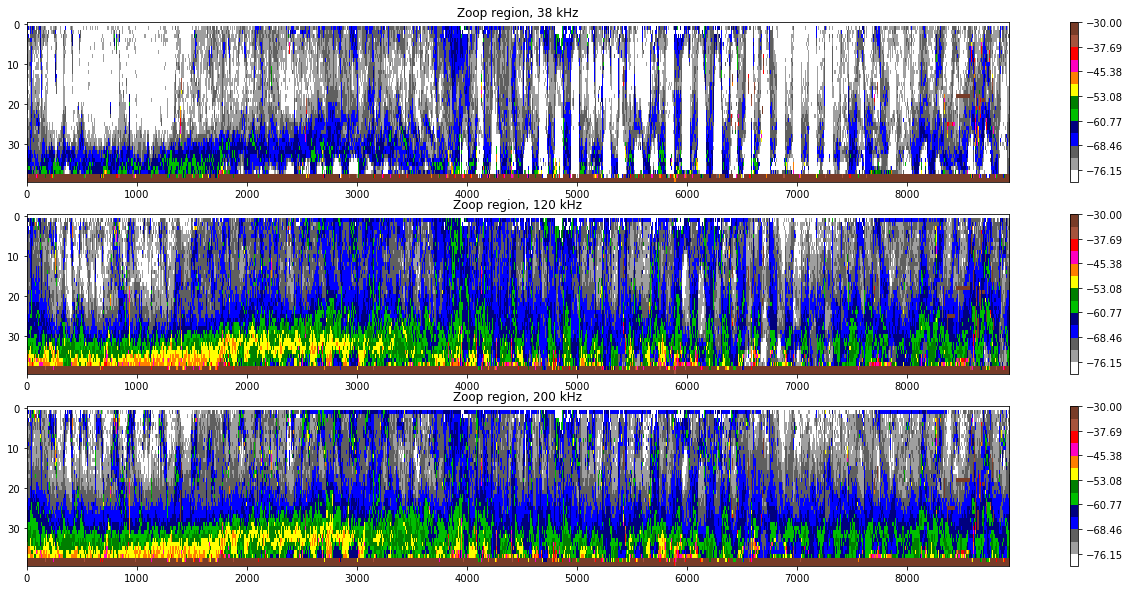

In [583]:
fig,(ax0,ax1,ax2) = plt.subplots(3,1,figsize=(22,10))
im0 = ax0.imshow(np.ma.masked_where(~idx_zoop,MVBS[0,:,:]),aspect='auto',cmap=e_cmap,norm=e_norm)
fig.colorbar(im0,ax=ax0)
ax0.set_title('Zoop region, 38 kHz')
im1 = ax1.imshow(np.ma.masked_where(~idx_zoop,MVBS[1,:,:]),aspect='auto',cmap=e_cmap,norm=e_norm)
fig.colorbar(im1,ax=ax1)
ax1.set_title('Zoop region, 120 kHz')
im2 = ax2.imshow(np.ma.masked_where(~idx_zoop,MVBS[2,:,:]),aspect='auto',cmap=e_cmap,norm=e_norm)
fig.colorbar(im2,ax=ax2)
ax2.set_title('Zoop region, 200 kHz')